### Creating representative observations for Clyfar and the Uinta Basin
We will load 2022/2023 and reduce observation set to daily representative values.

We seek single values for:
* Wind speed (mid-upper percentile to ignore thunderstorm gusts etc)
* MSLP (calibrate to find something not buggered by altitude calculations)
* Insolation (I was using "near zenith mean" for 10-14: around solar noon)
* Snow depth (data is sparse, so we need to make most of COOP sites once a day)
* NEW: pseudo-lapse-rate, using temperature and altitude values up the slope to estimate a lapse rate and perhaps detect a shallow cold pool
* NEW: soil temperature, which may be correlated with snow-melt and hence more difficult inversion formation

We can then start to relate things day-to-day. Note our days will be local, meaning offset from UTC of -6 or -7 depending on daylight savings.

In [25]:
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from obs.obsdata import ObsData

plt.rc('text', usetex=False)
plt.rc('font', family='Helvetica')

# Set dpi = 350 
plt.rcParams['figure.dpi'] = 350

# pastel colour set for multiple lines on plot
mycolors = ['#FFA07A', '#20B2AA', '#778899', '#FF6347', '#4682B4', '#FFD700',
            '#8A2BE2', '#00FF7F', '#FF4500', '#00FFFF']

# Define the maroon/purple color for the example lines
fave_color = '#4B0082'

colors = {
    "ozone": "#5D3A9B",
    "mslp": "#4C72B0",
    "wind": "#55A868",
    "snow": "#00BFFF",
    "solar": "#E17C05"
}


In [26]:
# Hard code the choice of stations that go into the pot of representative value functions.
# Mix of reliability, minimum of filtering, and 5-year span for "learning" if possible

snow_stids = ['COOPJENU1', 'COOPFTDU1', 'COOPALMU1', 'COOPDINU1', 'COOPROSU1',
              'COOPVELU1', 'COOPDSNU1', 'COOPOURU1', 'COOPNELU1']
wind_stids = ['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']
solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"]
ozone_stids = ["QV4", "QRS"]
mslp_stids = ["KVEL",]

In [27]:
# "sea_level_pressure" from KVEL will be the source. We take the median of daily values.

def do_repval_mslp(df, stids, vrbl_col="sea_level_pressure", stid_col="stid"):
    """Create representative values of mean sea level pressure from KVEL data.
    
    Notes:
        This is currently the variable "sea_level_pressure" from the station KVEL, 
        ignoring "pressure" and "altimeter". Further, we note the index
        is in UTC and we need to shift to local time (US Mountain) considering
        the daylight savings change.
        
    Args:
        df (pd.DataFrame): The data frame with raw-ish data of 
                        various stids and time frequencies and variables
        stids (list): The list of station IDs to consider for this calculation 
        vrbl_col (str): The column name for the variable of interest
        stid_col (str): The column name for the station ID
        
    Returns:
        repr_df (pd.DataFrame): Time series of representative values of MSLP
                                    for the Basin
    """
    # Subset to just the stids and the two columns for the variable and station ID
    # (Those keys are set in the function signature)
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]
    
    # We need to convert the index to local time
    df.index = df.index.tz_convert("US/Mountain")
    
    # We first reduce the dataset to daily values for each station computed
    # as the median of that station's values for that day.
    repr_df = df.groupby(stid_col).resample('D').median()
       
    # We then take the median over all stations for each day to create the representative value
    repr_df = repr_df.groupby(level=1).median()
    
    return repr_df
    

In [28]:
def do_repval_ozone(df, stids, vrbl_col="ozone_concentration", stid_col="stid"):
    """Create representative values of ozone concentration from multiple reliable stations.
    
    Args:
        df (pd.DataFrame): The data frame with the ozone data where columns are station IDs
            (stid), and ozone_concentration, and the index is a timestamp.
    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # Remove extreme values
    df.loc[df[vrbl_col] > 140, vrbl_col] = np.nan
    df.loc[df[vrbl_col] < 5, vrbl_col] = np.nan

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # First get the 99th percentile for each station, resampled daily (midnight to midnight)
    daily_99th = df.groupby(stid_col).resample('D').quantile(0.99)

    # For each day, take the 99th percentile of the daily 99th percentiles across stations for a single value per day
    result = daily_99th.groupby(level=1).quantile(0.99)

    return result


In [29]:
def do_repval_wind(df, stids, vrbl_col="wind_speed", stid_col="stid"):
    """Create representative values of wind speed from a subset of Uinta Basin stations.

    Args:
        df (pd.DataFrame): The data frame with the wind speed data where columns are the stations
        
    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]
    
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # First get 75th percentile of each station midnight to midnight local time
    daily_75th = df.groupby(stid_col).resample("D").quantile(0.75)
    
    # Then the 95th percentile of those values
    result = daily_75th.groupby(level=1).quantile(0.75)
    
    return result 

In [30]:
def do_repval_snow(df, stids, vrbl_col="snow_depth", stid_col="stid"):
    """Create representative values of snow from the Uinta Basin stations.
    
    Notes:
        We use the stations "COOP*" in the Basin.

    Args:
        df (pd.DataFrame): The data frame with the snow data for all COOP stations 
        
    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]
    
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # Compute 95th percentile of snow depth for each station's reports midnight to midnight local time
    daily_95th = df.groupby(stid_col).resample("D").quantile(0.95)
    
    # Then the 95th percentile of those values
    result = daily_95th.groupby(level=1).quantile(0.95)
    
    return result

In [31]:
def compute_nearzenithmean(df, solar_stids, vrbl_col="solar_radiation", stid_col="stid"):
    # Create a dictionary to store this "near-zenith mean" (nzm) for each station
    daily_solar_nzm = dict()

    for stid in solar_stids:
        # Get the time series for this station, only for the variable column
        sub_df = df.loc[df[stid_col] == stid, vrbl_col]
        
        # For each station, compute mean from obs within each local day for the variable column
        daily_solar_nzm[stid] = sub_df.between_time("10:00", "14:00").resample("D").mean()
    
    # Create dataframe
    df_daily_solar_nzm = pd.concat(daily_solar_nzm, axis=0, ignore_index=False)
    df_daily_solar_nzm = do_nzm_filtering(df_daily_solar_nzm, solar_stids)
    return df_daily_solar_nzm

def do_nzm_filtering(df, solar_stids):
    """Filter the near-zenith mean insolation data by adding a rolling mean.
    
    Note:
        The first six days will be NaN due to the window. Start a week early.
        TODO: add a week for the operational model before starting Clyfar
        
    Args:
        df (pd.DataFrame): The data frame with the near-zenith mean insolation data
        solar_stids (list): The list of station IDs for solar radiation
    """
    all_filtered = {}
    for stid in solar_stids:
        sub_df = df.loc[stid]
        filtered_sub_df = sub_df.rolling(window=7).mean()
        all_filtered[stid] = filtered_sub_df
    filtered_df = pd.concat(all_filtered, axis=0, ignore_index=False)
    return filtered_df    

def do_repval_solar(df, stids, vrbl_col="solar_radiation", stid_col="stid"):
    """Create representative values of insolation using "near-zenith mean" from four stations.
    
    Args:
        df (pd.DataFrame): The data frame with the insolation data where columns are the stations
        
    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]
    
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # Compute near-zenith mean for each station midnight to midnight local time
    df_daily_solar_nzm = compute_nearzenithmean(df, solar_stids)
    
    # 95th percentile 
    result = df_daily_solar_nzm.groupby(level=1).quantile(0.95)
    
    return result 

In [32]:
df, meta_df = ObsData.load_dfs("../data", "UB_obs_2022.parquet")
df.head(10)

air_temp      altimeter  ceiling  \
date_time                                                     
2021-12-01 00:00:00+00:00       6.0  102641.390625      NaN   
2021-12-01 00:05:00+00:00       3.0  102641.390625      NaN   
2021-12-01 00:10:00+00:00       1.0  102641.390625      NaN   
2021-12-01 00:15:00+00:00       0.0  102675.257812      NaN   
2021-12-01 00:20:00+00:00       0.0  102675.257812      NaN   
2021-12-01 00:25:00+00:00       1.0  102709.117188      NaN   
2021-12-01 00:30:00+00:00       0.0  102709.117188      NaN   
2021-12-01 00:35:00+00:00      -1.0  102709.117188      NaN   
2021-12-01 00:40:00+00:00      -1.0  102709.117188      NaN   
2021-12-01 00:45:00+00:00       0.0  102709.117188      NaN   

                           dew_point_temperature_set_1  dew_point_temperature  \
date_time                                                                       
2021-12-01 00:00:00+00:00                          NaN                  -4.11   
2021-12-01 00:05:00+00:00                          NaN                  -5.11   
2021-12-01 00:10:00+00:00                          NaN                  -6.10   
2021-12-01 00:15:00+00:00                          NaN                  -6.09   
2021-12-01 00:20:00+00:00                          NaN                  -6.09   
2021-12-01 00:25:00+00:00                          NaN                  -6.10   
2021-12-01 00:30:00+00:00                          NaN                  -6.09   
2021-12-01 00:35:00+00:00                          NaN                  -6.08   
2021-12-01 00:40:00+00:00                          NaN                  -6.08   
2021-12-01 00:45:00+00:00                          NaN                  -6.09   

                               pressure  sea_level_pressure_set_1  \
date_time                                                           
2021-12-01 00:00:00+00:00  84559.132812                       NaN   
2021-12-01 00:05:00+00:00  84559.132812                       NaN   
2021-12-01 00:10:00+00:00  84559.132812                       NaN   
2021-12-01 00:15:00+00:00  84587.031250                       NaN   
2021-12-01 00:20:00+00:00  84587.031250                       NaN   
2021-12-01 00:25:00+00:00  84614.929688                       NaN   
2021-12-01 00:30:00+00:00  84614.929688                       NaN   
2021-12-01 00:35:00+00:00  84614.929688                       NaN   
2021-12-01 00:40:00+00:00  84614.929688                       NaN   
2021-12-01 00:45:00+00:00  84614.929688                       NaN   

                           sea_level_pressure  wind_direction  wind_speed  \
date_time                                                                   
2021-12-01 00:00:00+00:00       102527.593750             0.0       0.000   
2021-12-01 00:05:00+00:00       102738.476562           280.0       1.543   
2021-12-01 00:10:00+00:00       102881.851562           250.0       1.543   
2021-12-01 00:15:00+00:00       102988.328125           270.0       1.543   
2021-12-01 00:20:00+00:00       102988.328125           290.0       1.543   
2021-12-01 00:25:00+00:00       102949.742188           310.0       1.543   
2021-12-01 00:30:00+00:00       103022.296875           310.0       1.543   
2021-12-01 00:35:00+00:00       103095.437500           290.0       2.572   
2021-12-01 00:40:00+00:00       103095.437500           260.0       2.058   
2021-12-01 00:45:00+00:00       103022.296875           250.0       3.087   

                           ...  soil_temp  soil_temp_set_2 soil_temp_set_3  \
date_time                  ...                                               
2021-12-01 00:00:00+00:00  ...        NaN              NaN             NaN   
2021-12-01 00:05:00+00:00  ...        NaN              NaN             NaN   
2021-12-01 00:10:00+00:00  ...        NaN              NaN             NaN   
2021-12-01 00:15:00+00:00  ...        NaN              NaN             NaN   
2021-12-01 00:20:00+00:00  ...        NaN              NaN             NaN 

In [33]:
df.columns

Index(['air_temp', 'altimeter', 'ceiling', 'dew_point_temperature_set_1',
       'dew_point_temperature', 'pressure', 'sea_level_pressure_set_1',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'wind_u',
       'wind_v', 'stid', 'snow_depth', 'snow_water_equiv', 'solar_radiation',
       'dew_point_temperature_set_1d', 'soil_temp', 'soil_temp_set_2',
       'soil_temp_set_3', 'soil_temp_set_4', 'soil_temp_set_5',
       'NOx_concentration', 'ozone_concentration', 'PM_25_concentration',
       'outgoing_radiation_sw', 'PM_25_concentration_set_2'],
      dtype='object')

In [34]:
# What to use for MSLP - "altimeter", "pressure", "sea_level_pressure"? Let's look at the column details
# only for stid = "KVEL".

df_kvel = df[df["stid"] == "KVEL"][["altimeter", "pressure", "sea_level_pressure"]]
df_kvel

# So we'll use sea_level_pressure. 


altimeter      pressure  sea_level_pressure
date_time                                                                 
2021-12-01 00:00:00+00:00  102641.390625  84559.132812       102527.593750
2021-12-01 00:05:00+00:00  102641.390625  84559.132812       102738.476562
2021-12-01 00:10:00+00:00  102641.390625  84559.132812       102881.851562
2021-12-01 00:15:00+00:00  102675.257812  84587.031250       102988.328125
2021-12-01 00:20:00+00:00  102675.257812  84587.031250       102988.328125
...                                  ...           ...                 ...
2022-03-14 23:45:00+00:00  102641.390625  84559.132812       102254.046875
2022-03-14 23:50:00+00:00  102641.390625  84559.132812       102254.046875
2022-03-14 23:53:00+00:00  102641.390625  84559.132812       102254.062500
2022-03-14 23:55:00+00:00  102641.390625  84559.132812       102254.046875
2022-03-15 00:00:00+00:00  102641.390625  84559.132812       102321.687500

[32623 rows x 3 columns]

In [35]:
# repr_mslp = do_repval_mslp(df[["sea_level_pressure",]])
repr_mslp = do_repval_mslp(df, mslp_stids)
repr_mslp

sea_level_pressure
date_time                                    
2021-11-30 00:00:00-07:00       103051.417969
2021-12-01 00:00:00-07:00       103197.406250
2021-12-02 00:00:00-07:00       102721.531250
2021-12-03 00:00:00-07:00       102674.148438
2021-12-04 00:00:00-07:00       102488.828125
...                                       ...
2022-03-10 00:00:00-07:00       102188.738281
2022-03-11 00:00:00-07:00       103214.332031
2022-03-12 00:00:00-07:00       102631.343750
2022-03-13 00:00:00-07:00       101651.351562
2022-03-14 00:00:00-06:00       102559.875000

[105 rows x 1 columns]

<Axes: xlabel='date_time'>

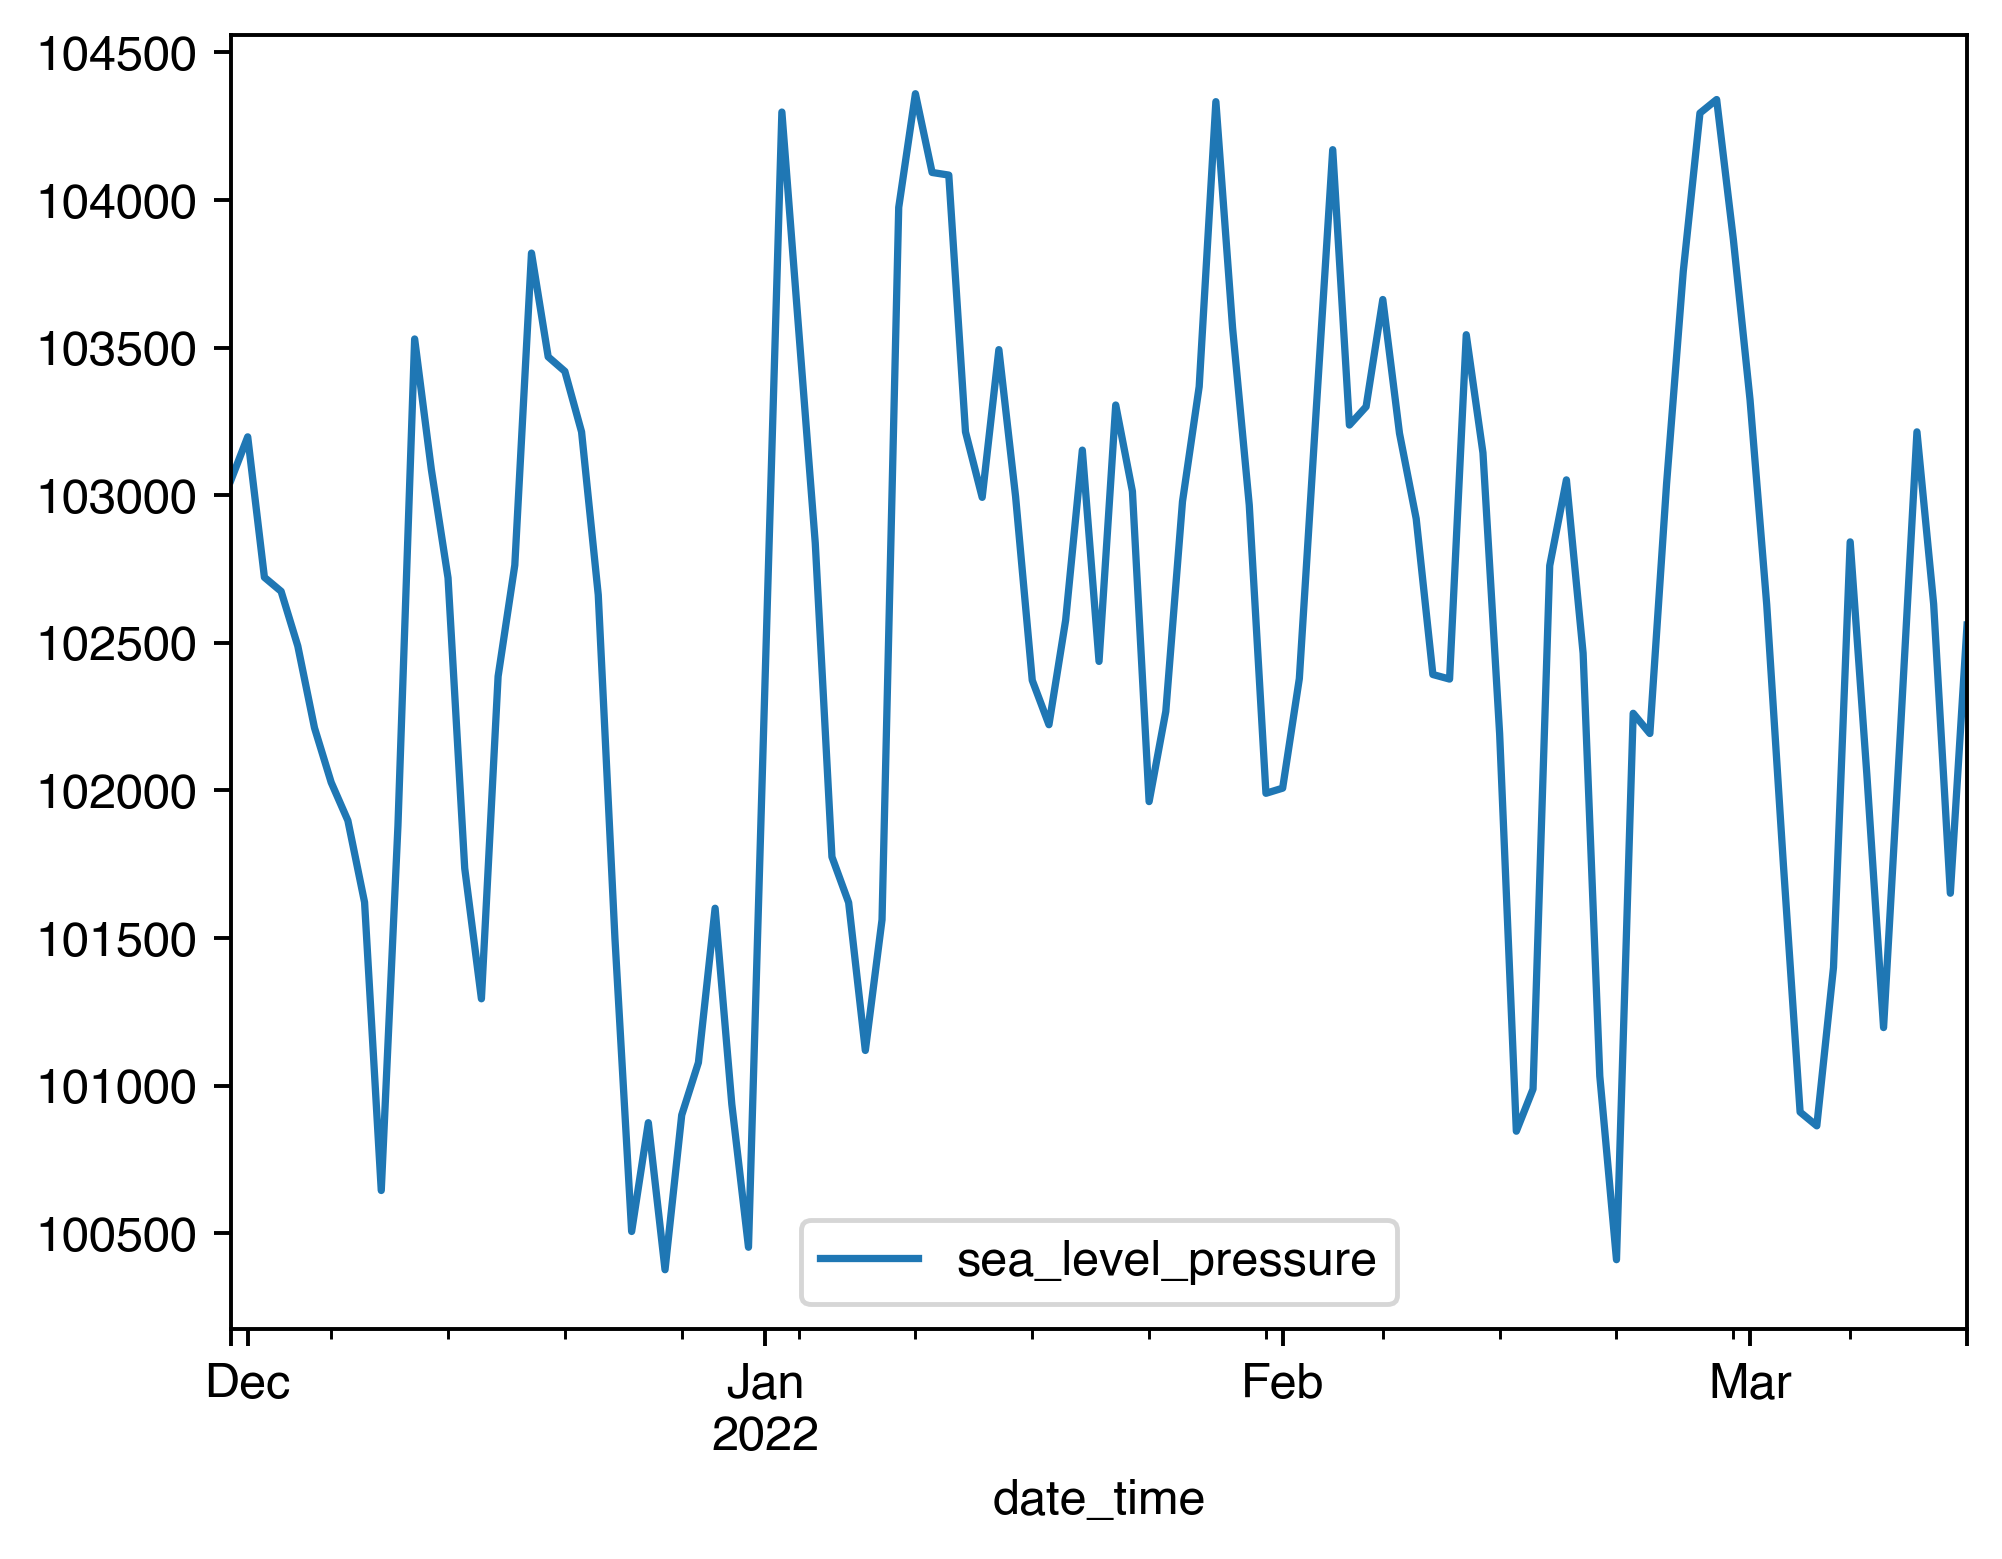

In [36]:
repr_mslp.plot()
# This method chosen due to wide variability so best to capture general trends with one reliable station.

# Low and high will be piecewise linear sigmoid-like functions.
# Medium will be a trapezium.

# Determining range and core of trapezia:

# Low: left (1), transitioning between 1010 and 1020 to right (0) 

# Med support: 1010 to 1035 
# Med core: 1020 to 1030 

# High support: left (0), transitioning between 1030 and 1035 to right (1)

In [37]:
# repr_ozone argument should be a subset for the three stations ["UBHSP", "QV4", "QRS"]
# and the ozone_concentration column
# ozone_subdf = df[df["stid"].isin(["QV4", "QRS"])][["ozone_concentration","stid"]]
# ozone_subdf = df[df["stid"].isin(["UBHSP", "QV4"])][["ozone_concentration","stid"]]
# repr_ozone = do_repval_ozone(ozone_subdf)
repr_ozone = do_repval_ozone(df, ozone_stids)
repr_ozone

ozone_concentration
date_time                                     
2021-11-30 00:00:00-07:00              31.4848
2021-12-01 00:00:00-07:00              43.5300
2021-12-02 00:00:00-07:00              42.7623
2021-12-03 00:00:00-07:00              41.7423
2021-12-04 00:00:00-07:00              45.7000
...                                        ...
2022-03-10 00:00:00-07:00              49.9800
2022-03-11 00:00:00-07:00              50.9700
2022-03-12 00:00:00-07:00              52.7623
2022-03-13 00:00:00-07:00              51.9478
2022-03-14 00:00:00-06:00              51.9882

[105 rows x 1 columns]

<Axes: xlabel='date_time'>

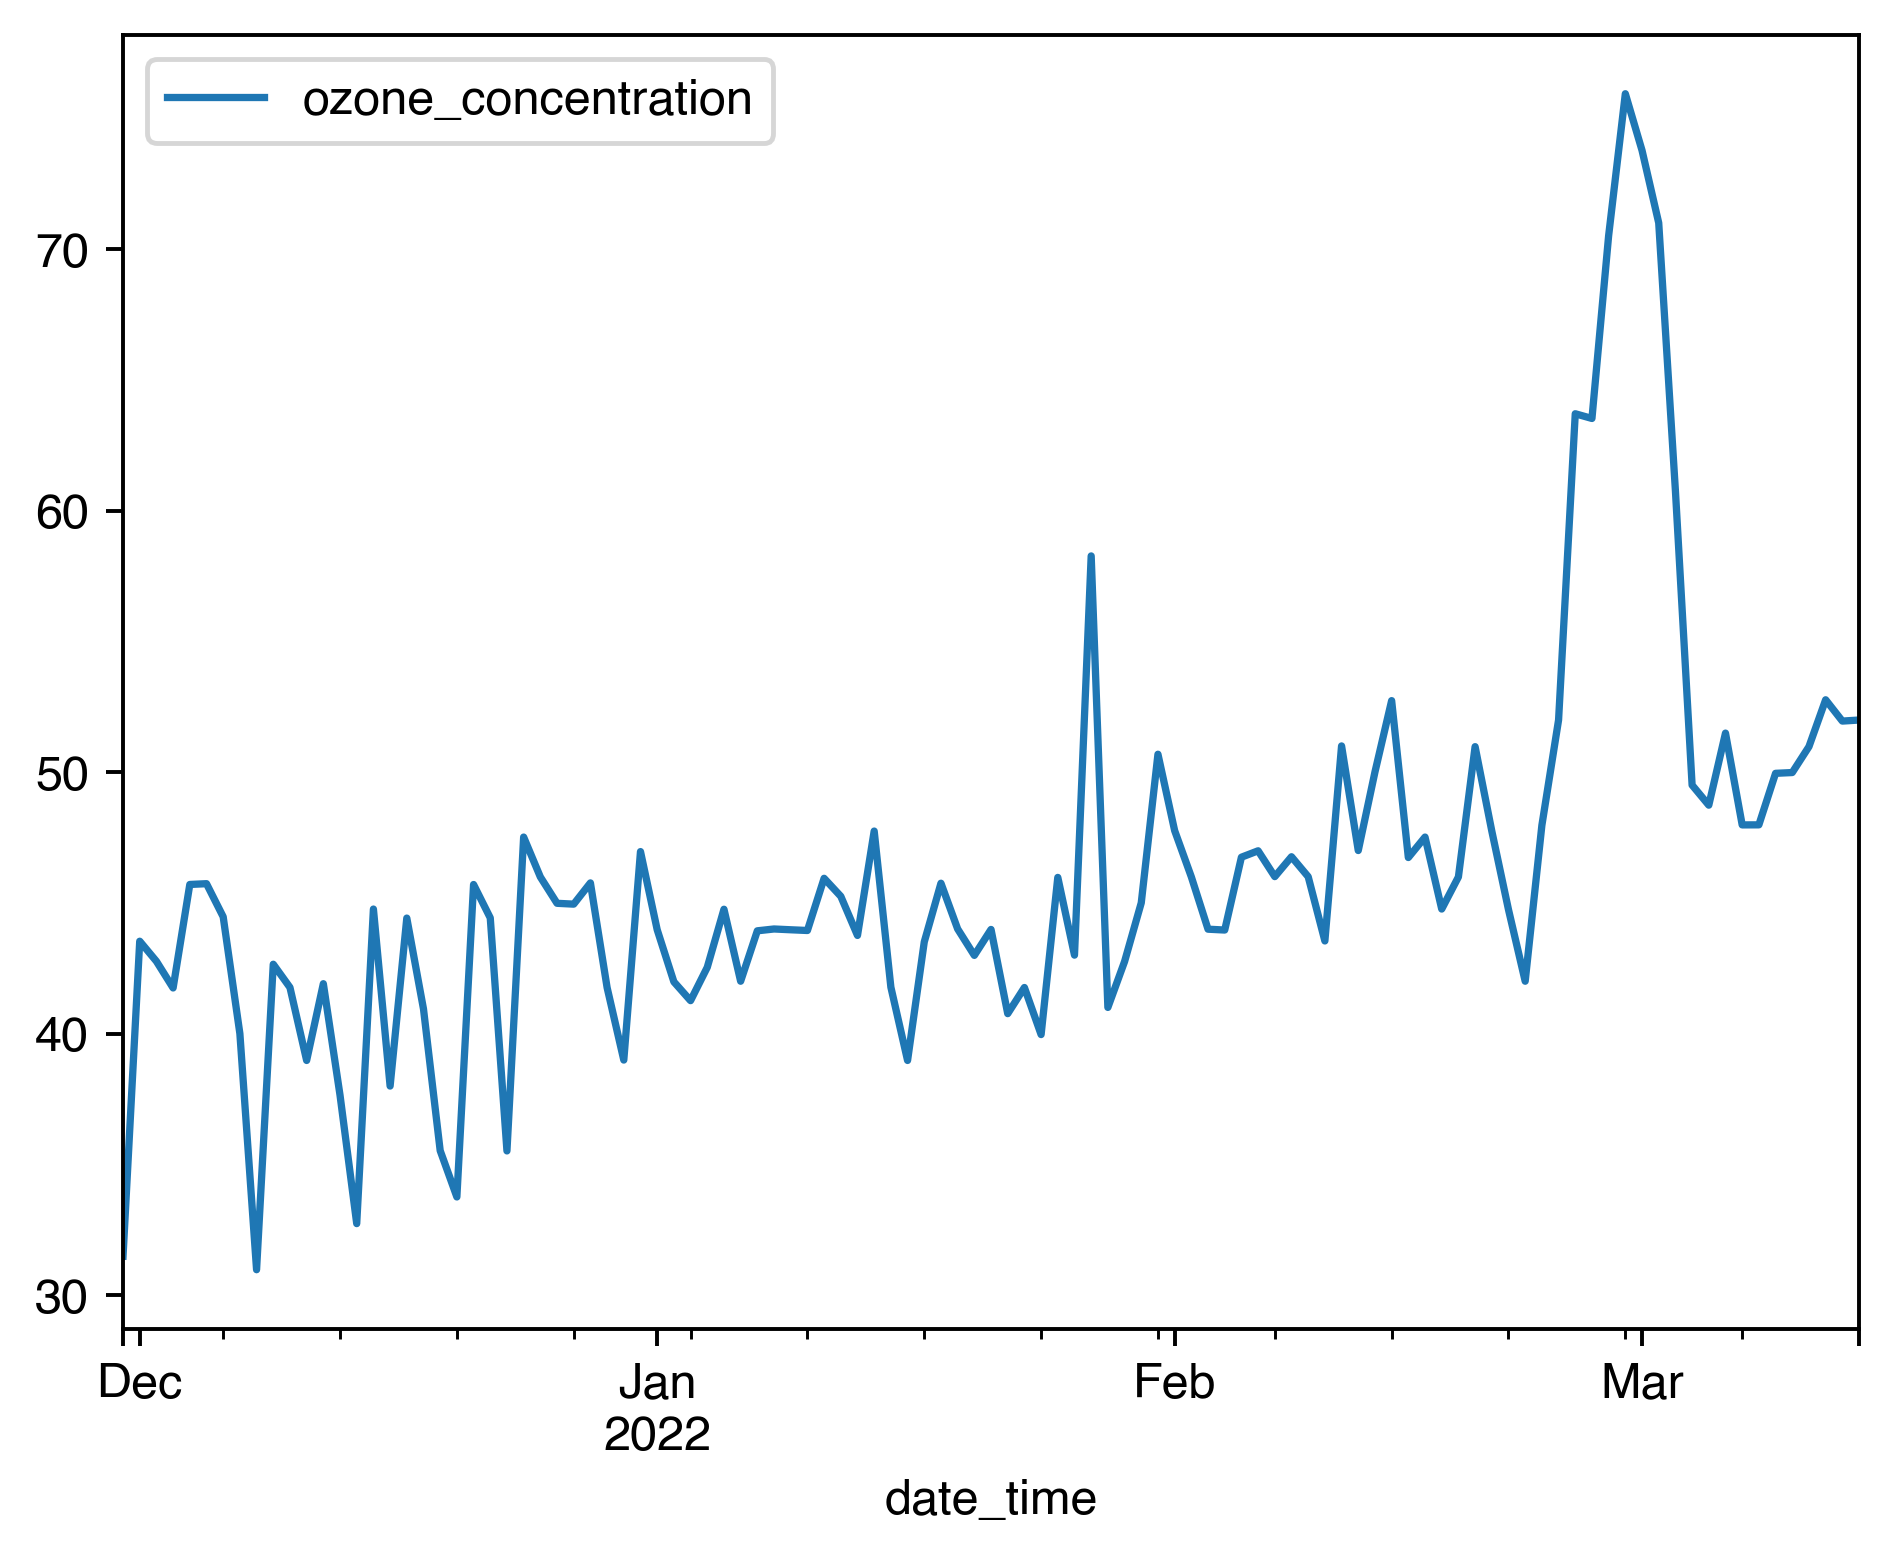

In [38]:
# Visualise repr_ozone 
repr_ozone.plot()

<Axes: xlabel='date_time'>

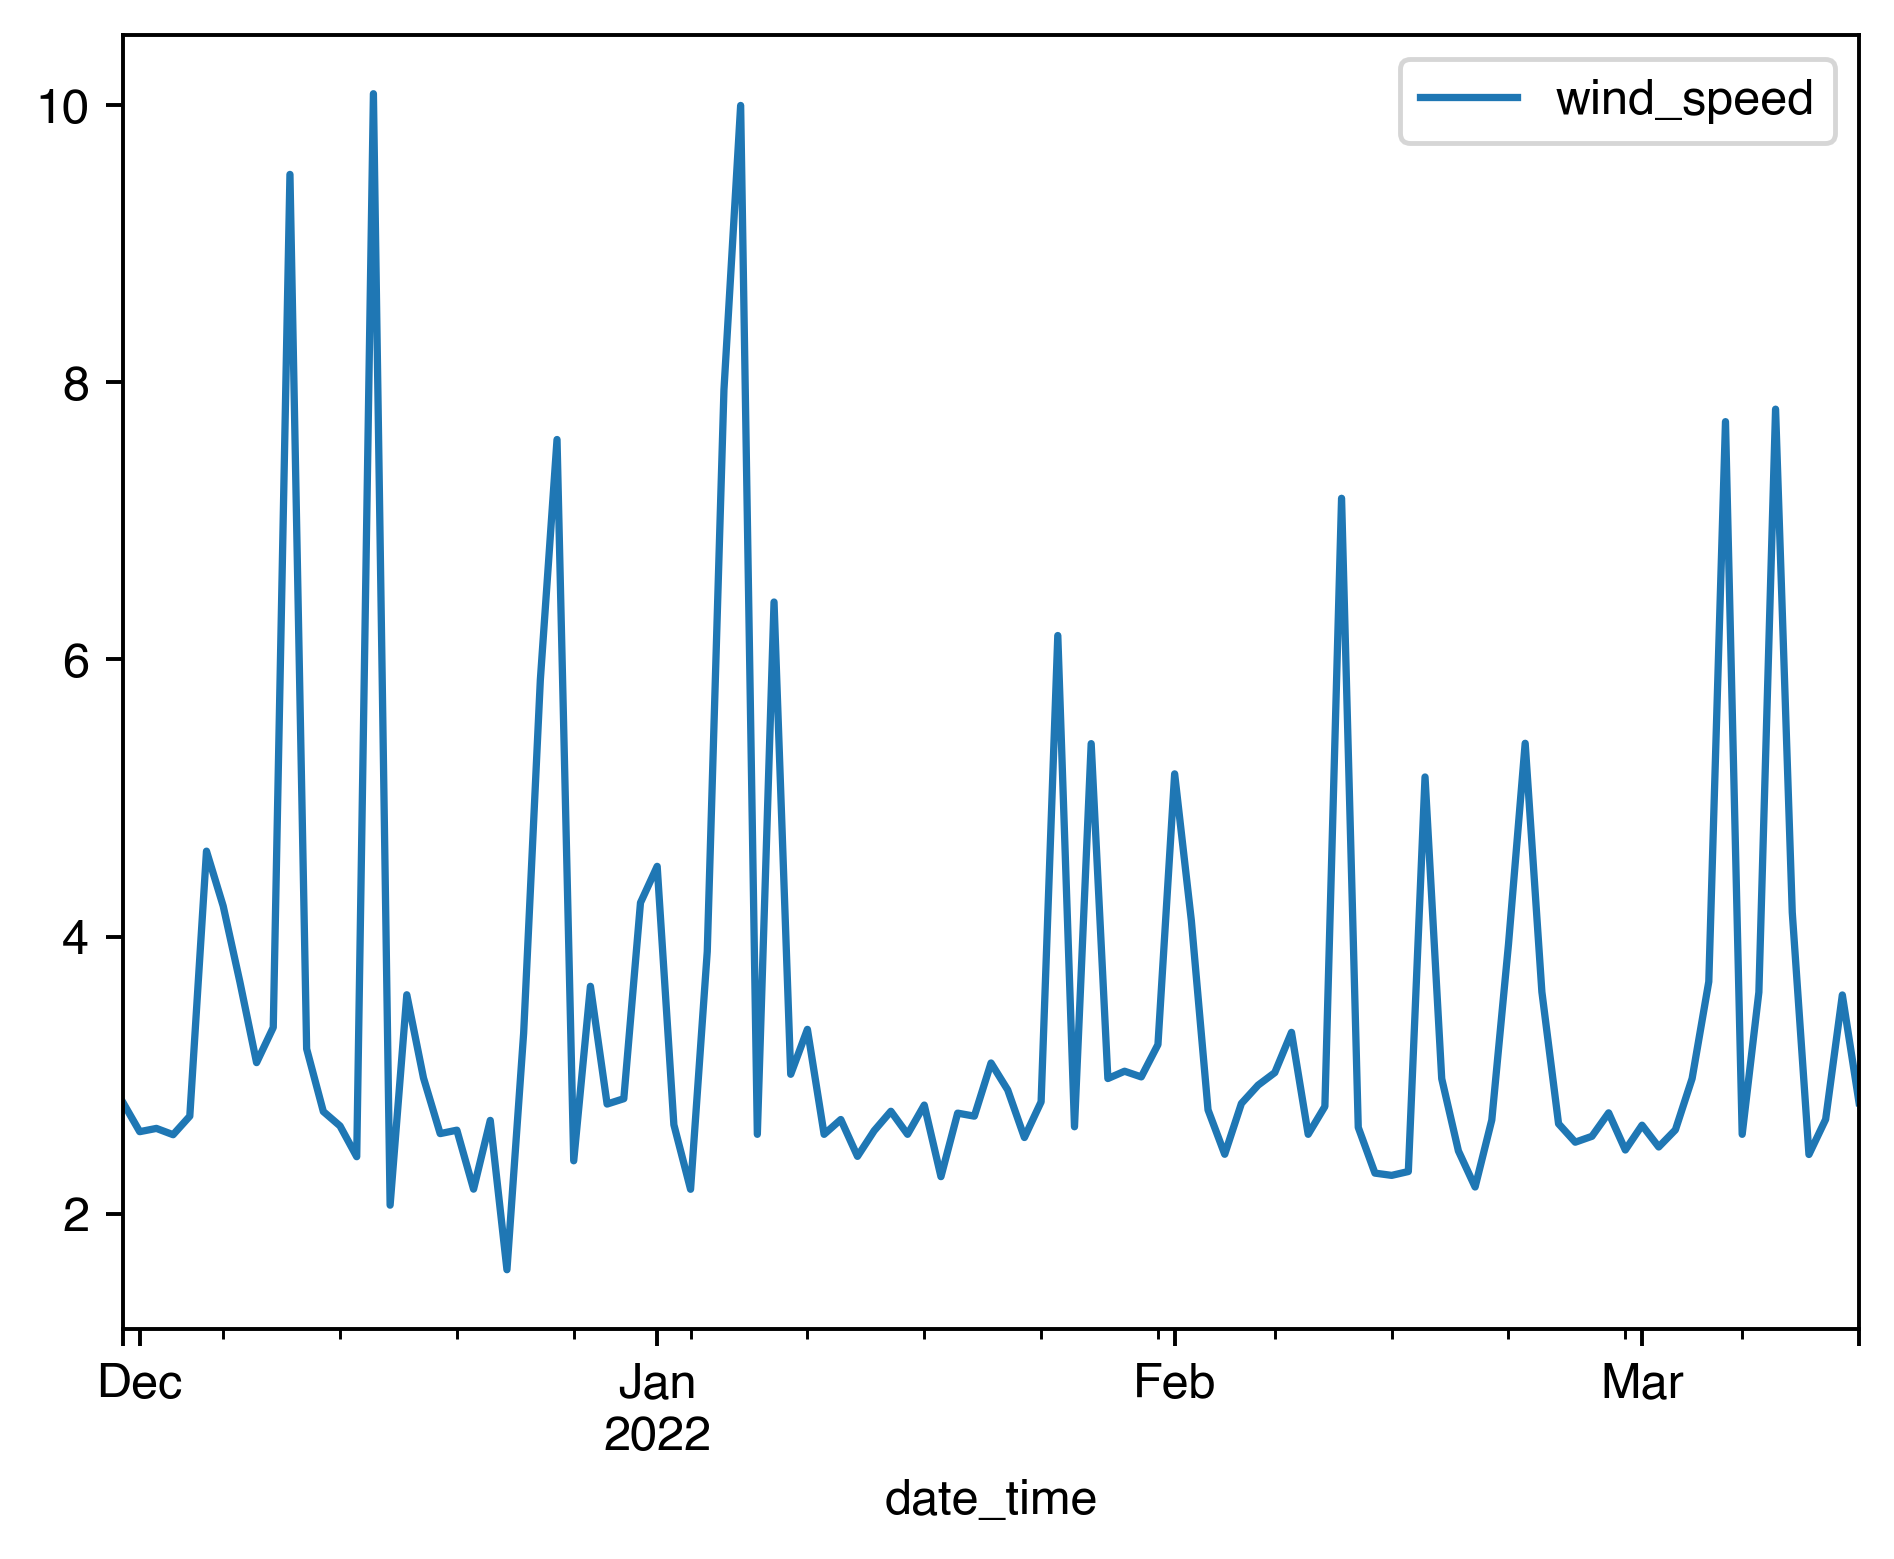

In [39]:
# How to generate wind speed? 
# wind_stids = ['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']
# repr_wind = do_repval_wind(df[df["stid"].isin(wind_stids)][["wind_speed","stid"]])
# repr_wind.plot()
# repr_wind
repr_wind = do_repval_wind(df, wind_stids)
repr_wind.plot()

<Axes: xlabel='date_time'>

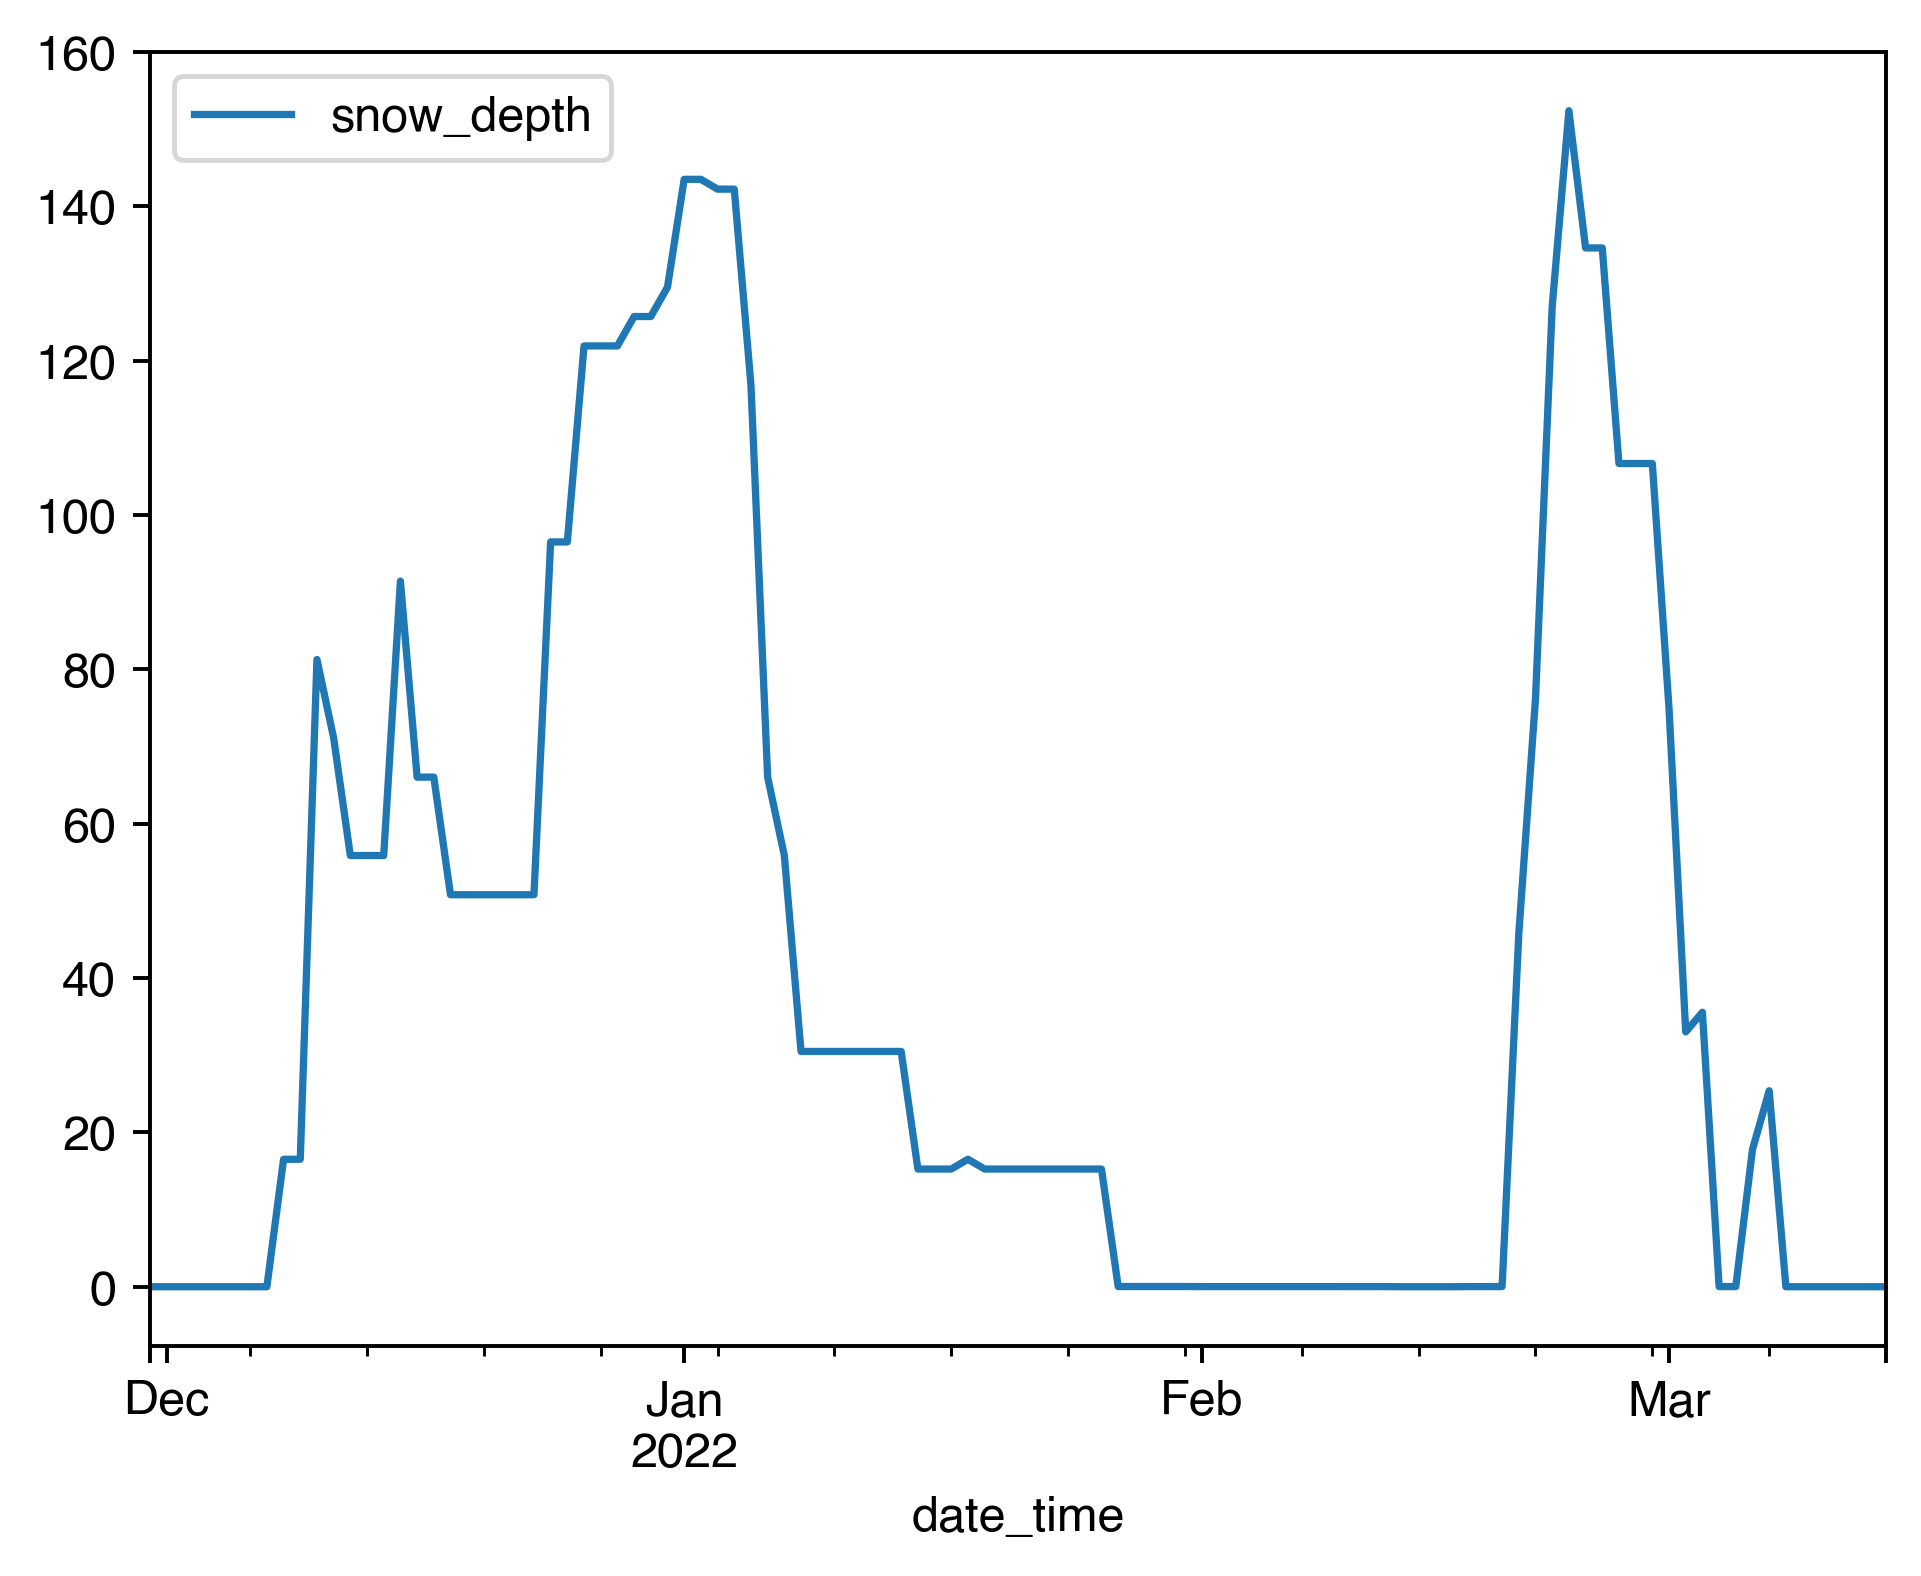

In [40]:
# snow_stids = ['COOPJENU1', 'COOPFTDU1', 'COOPALMU1', 'COOPDINU1', 'COOPROSU1', 
#                 'COOPVELU1', 'COOPDSNU1', 'COOPOURU1', 'COOPNELU1']
# repr_snow = do_repval_snow(df[df["stid"].isin(snow_stids)][["snow_depth","stid"]])
repr_snow = do_repval_snow(df, snow_stids)
repr_snow.plot()



<Axes: xlabel='date_time'>

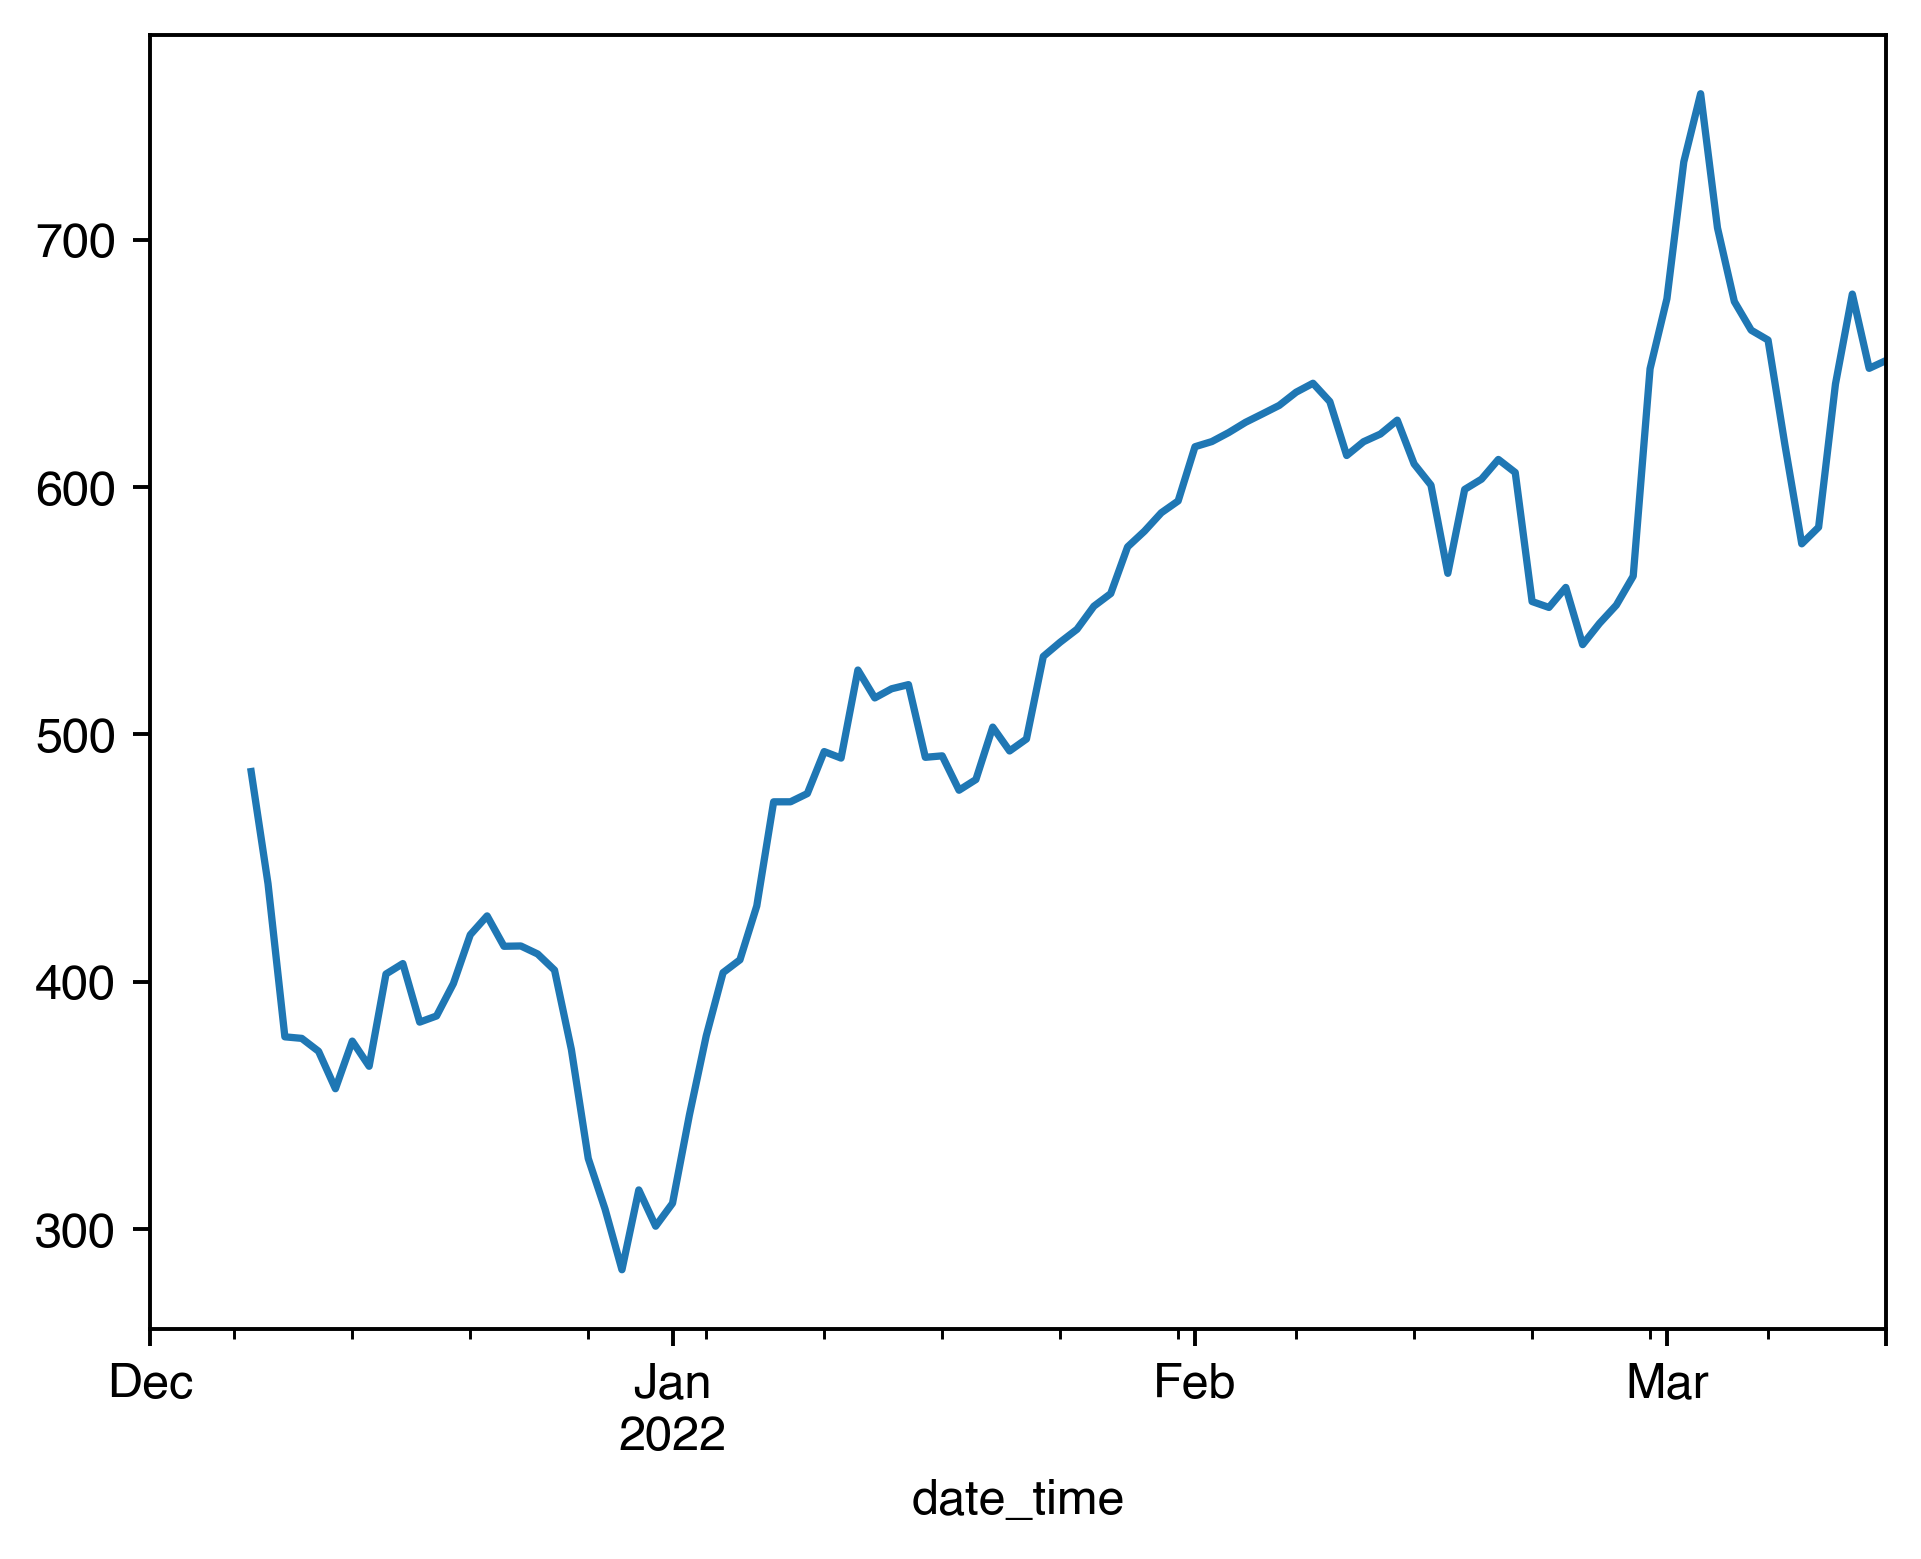

In [41]:
# solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"]
# solar_subset = df[df["stid"].isin(solar_stids)][["solar_radiation","stid"]]
# solar_subset
# repr_solar = do_repval_solar(df[df["stid"].isin(solar_stids)][["solar_radiation","stid"]])
repr_solar = do_repval_solar(df, solar_stids)
repr_solar.plot()

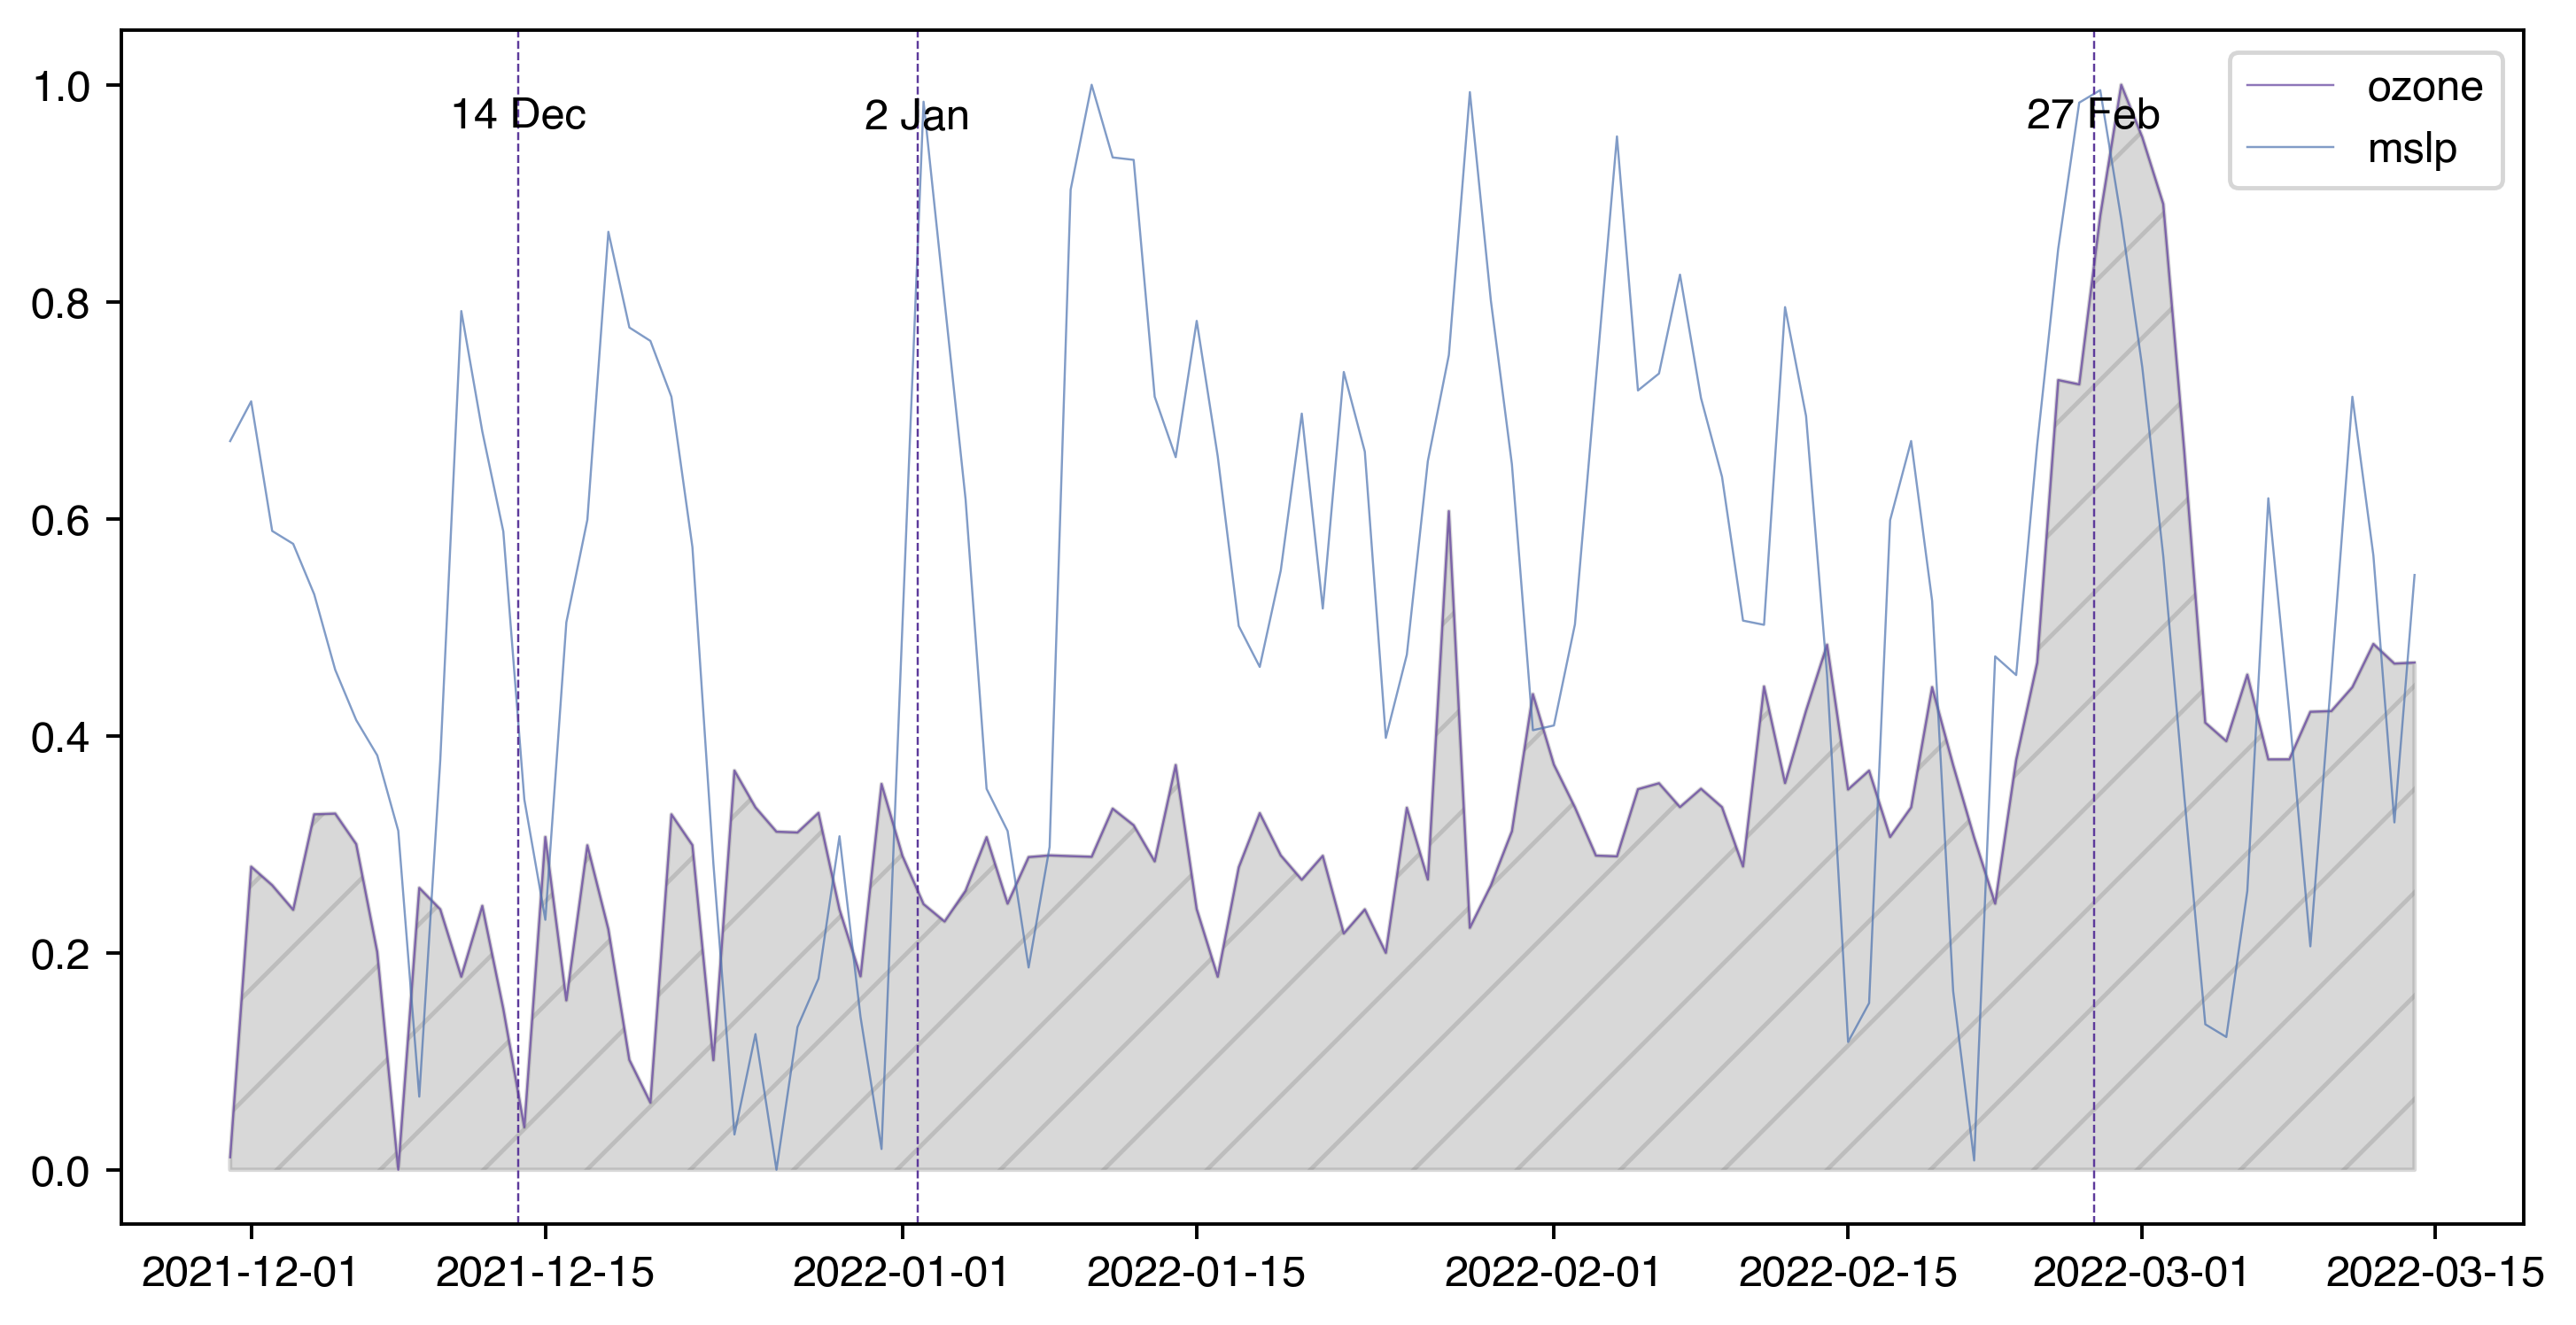

In [42]:

def normalize_and_plot(data_dict, labels, ax=None, colors=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    if colors is None:
        colors = {
            "ozone": "#5D3A9B",
            "mslp": "#4C72B0",
            "wind": "#55A868",
            "snow": "#00BFFF",  
            "solar": "#E17C05"
        }

    for label, data in zip(labels, data_dict.values()):
        if isinstance(data, pd.DataFrame):
            data = data.squeeze()  # Convert DataFrame to Series if necessary
        normalized_data = (data - data.min()) / (data.max() - data.min())
        ax.plot(data.index, normalized_data, label=label, lw=0.5, alpha=0.7, color=colors[label])
        if label == "ozone":
            ax.fill_between(data.index, normalized_data, alpha=0.3, hatch='/', color='gray')

    # For 2021/2022 case study
    annotate_dates = True
    if annotate_dates:
        # Add thick black lines with solid arrows for specific dates
        dates = ['2022-02-27', '2022-01-02', '2021-12-14']
        date_labels = ['27 Feb', '2 Jan', '14 Dec']
        for date, label in zip(dates, date_labels):
            date_timestamp = pd.Timestamp(date)
            ax.annotate('', xy=(date_timestamp, 0.96), xytext=(date_timestamp, 0.96),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=5, headwidth=10))
            ax.text(date_timestamp, 0.96, label, ha='center', fontsize=10)
            # Vertical grey lines for each date here 
            ax.axvline(date_timestamp, color=colors['ozone'], linestyle='--', lw=0.5)

    ax.legend()
    plt.show()
    return 

# Example usage
data_dict = {
    "ozone": repr_ozone,
    "mslp": repr_mslp,
    # "wind": repr_wind,
    # "snow": repr_snow,
    # "solar": repr_solar
}
labels = data_dict.keys()
normalize_and_plot(data_dict, labels)

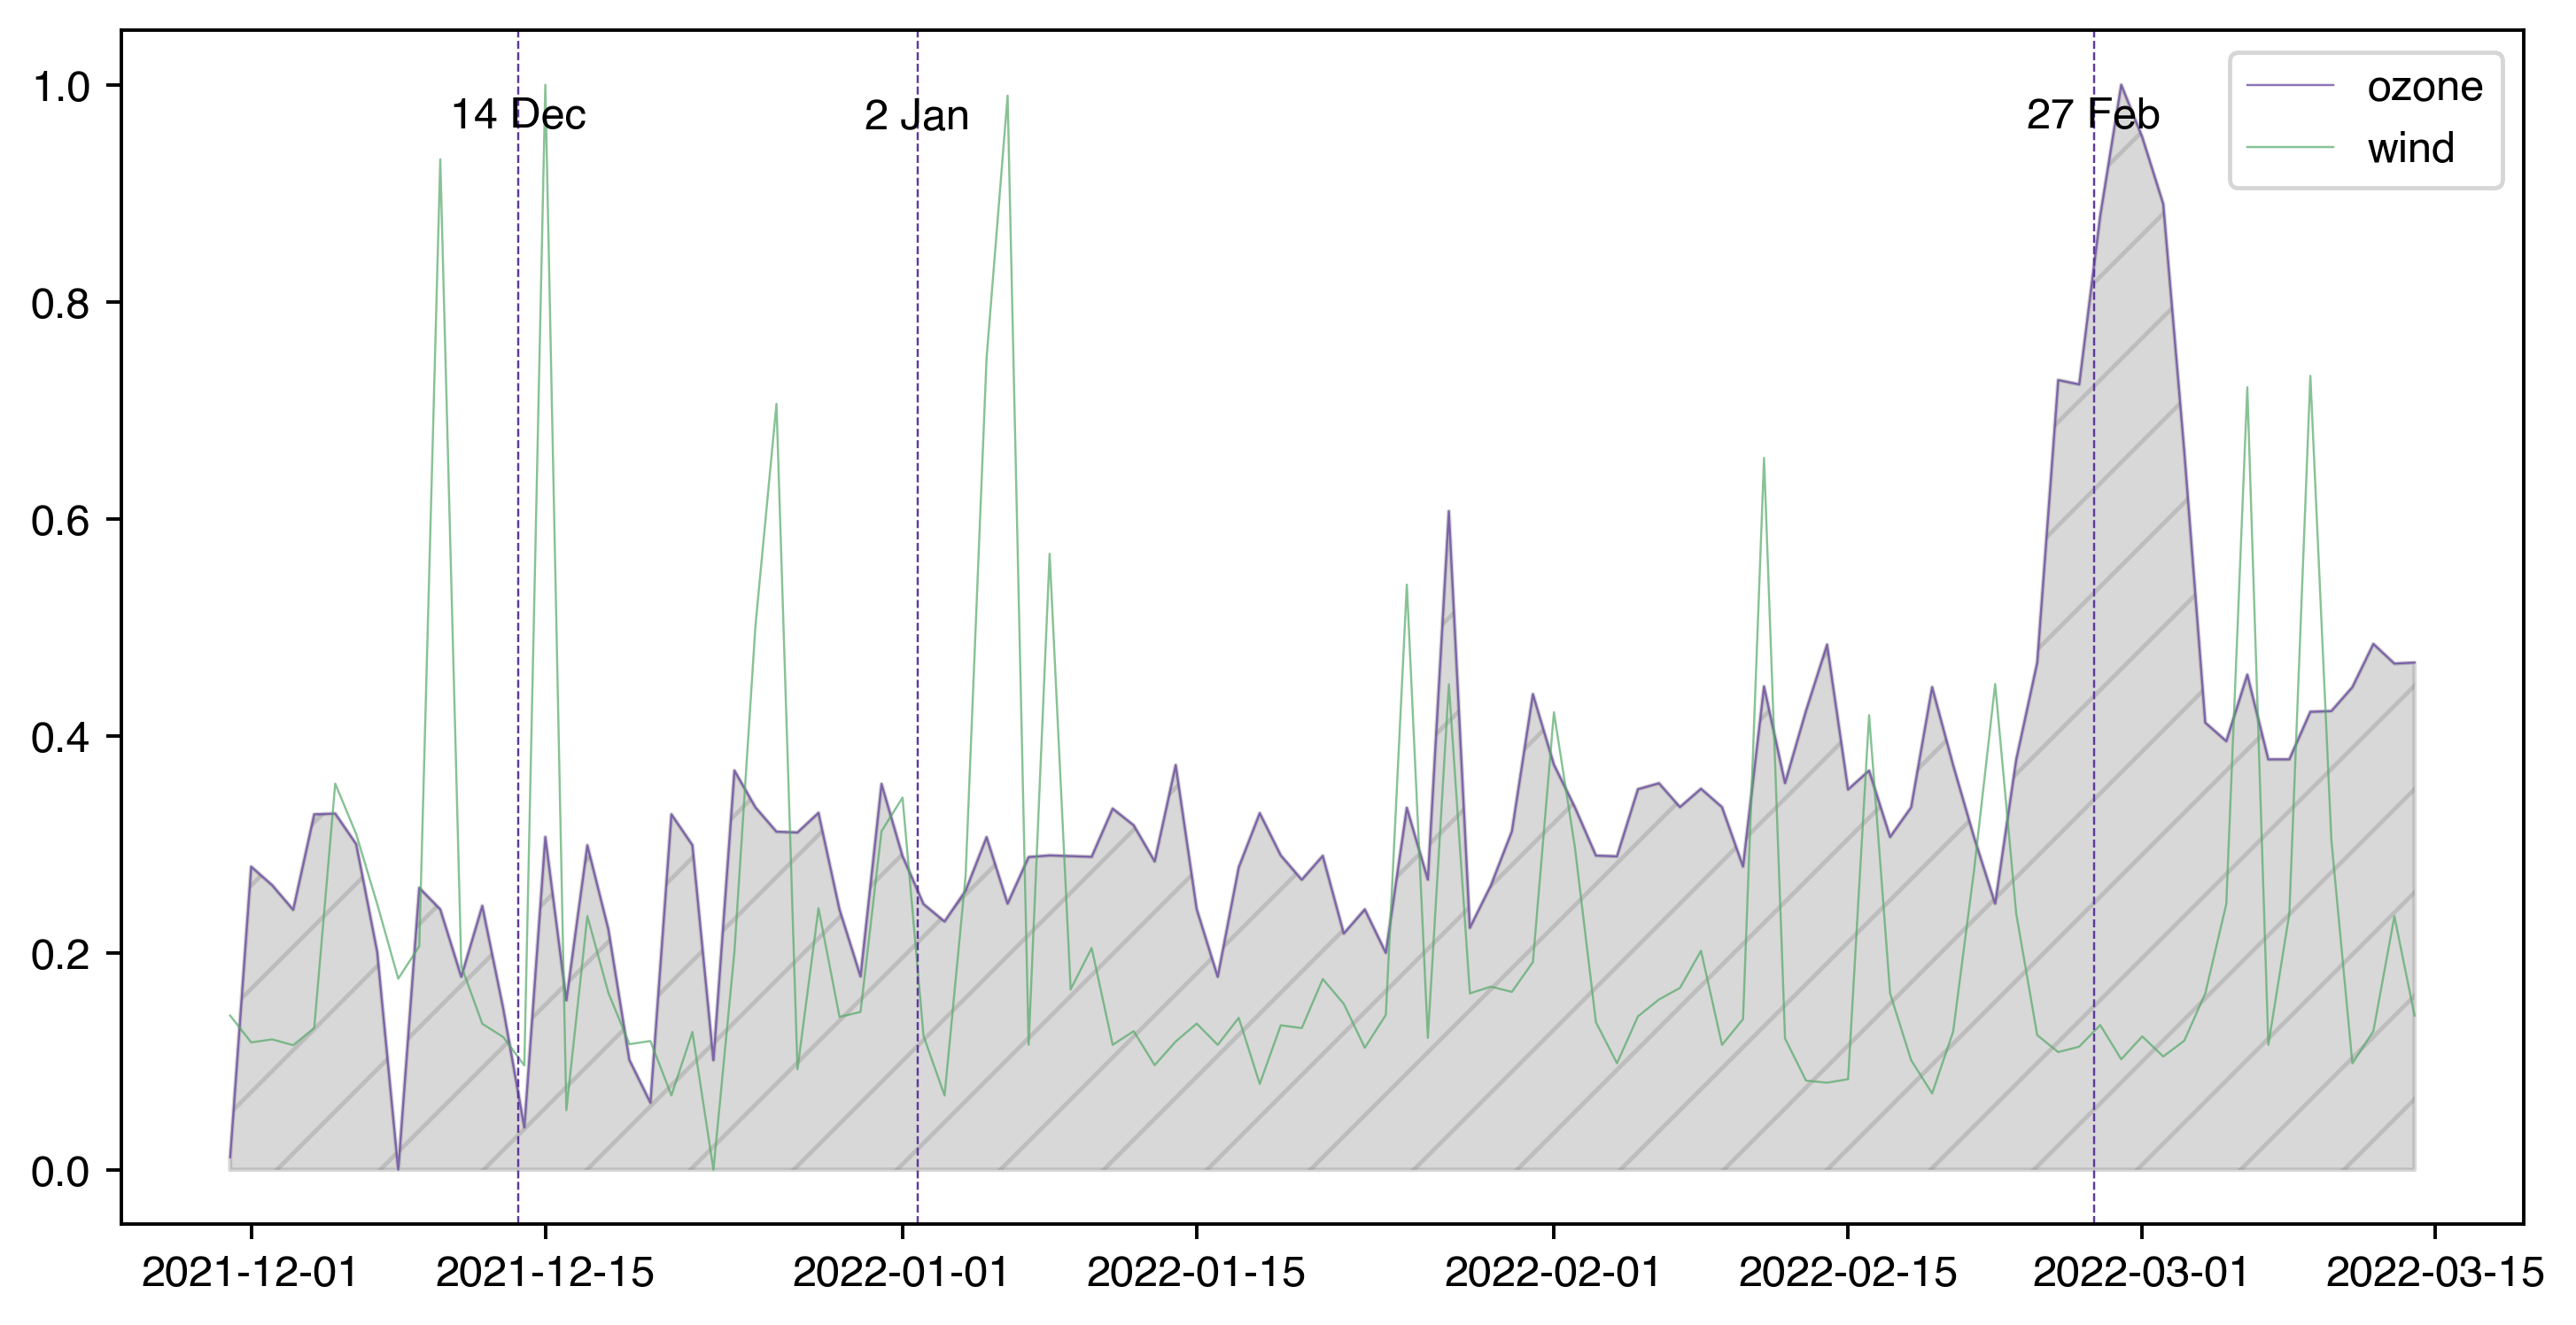

In [43]:

data_dict = {
    "ozone": repr_ozone,
    # "mslp": repr_mslp,
    "wind": repr_wind,
    # "snow": repr_snow,
    # "solar": repr_solar
}
labels = data_dict.keys()
normalize_and_plot(data_dict, labels)

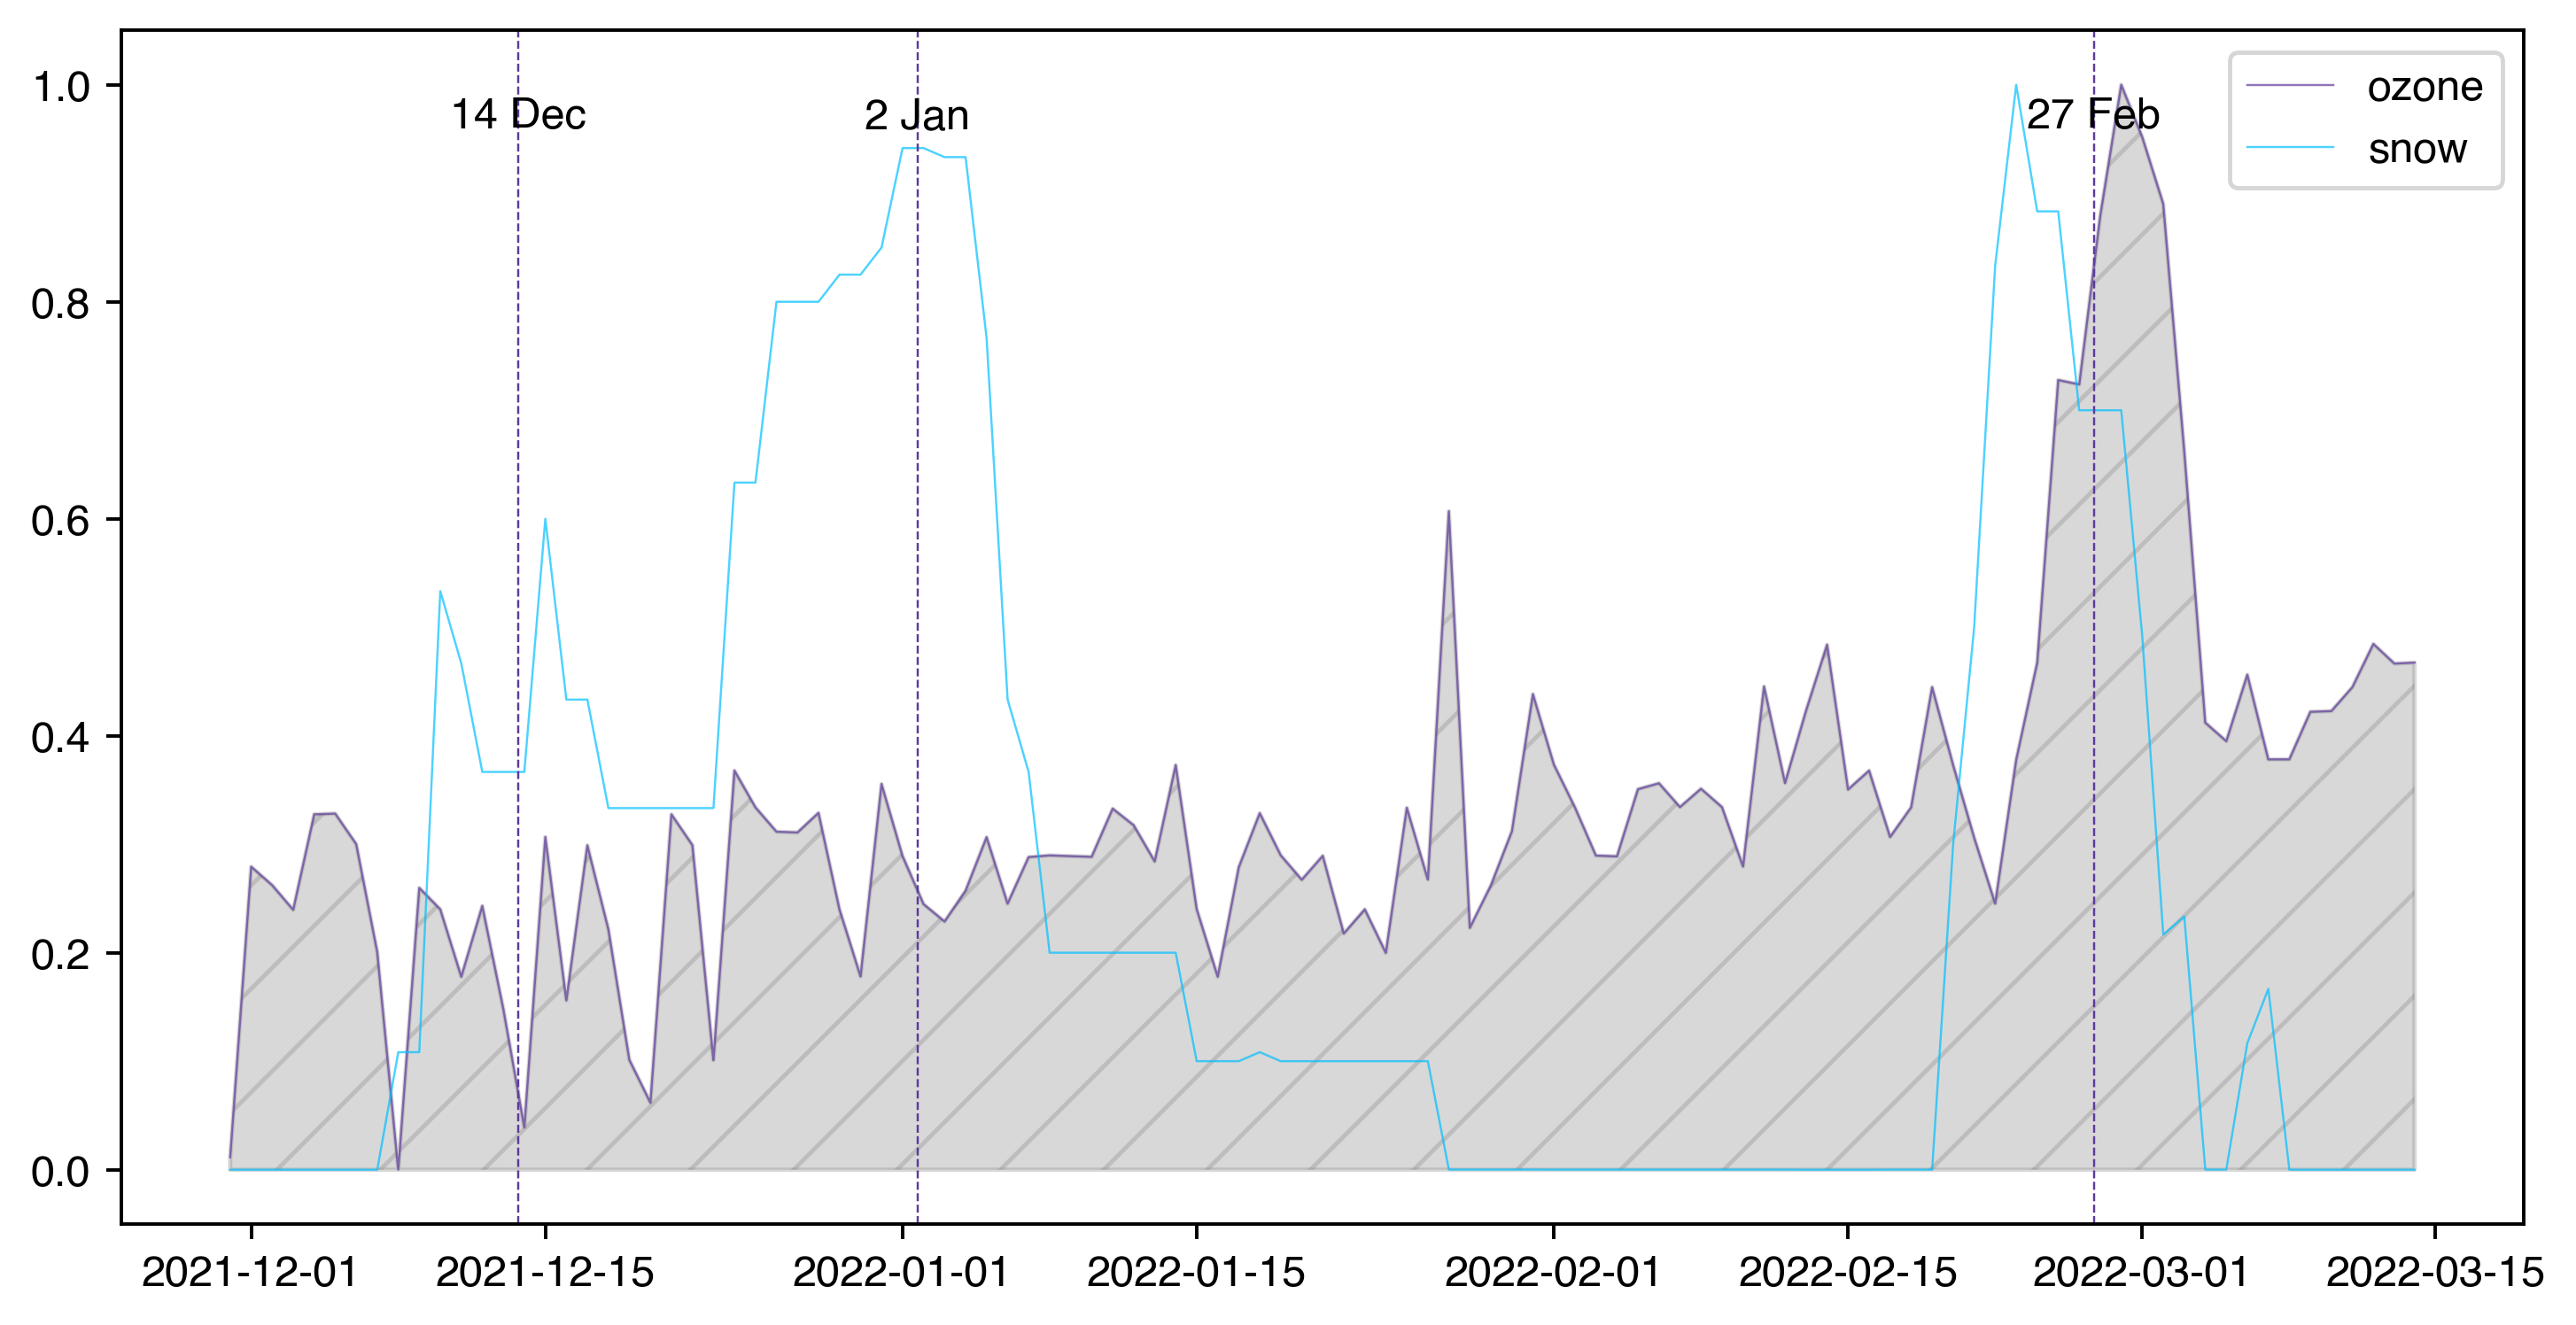

In [44]:
data_dict = {
    "ozone": repr_ozone,
    # "mslp": repr_mslp,
    # "wind": repr_wind,
    "snow": repr_snow,
    # "solar": repr_solar
}
labels = data_dict.keys()
normalize_and_plot(data_dict, labels)

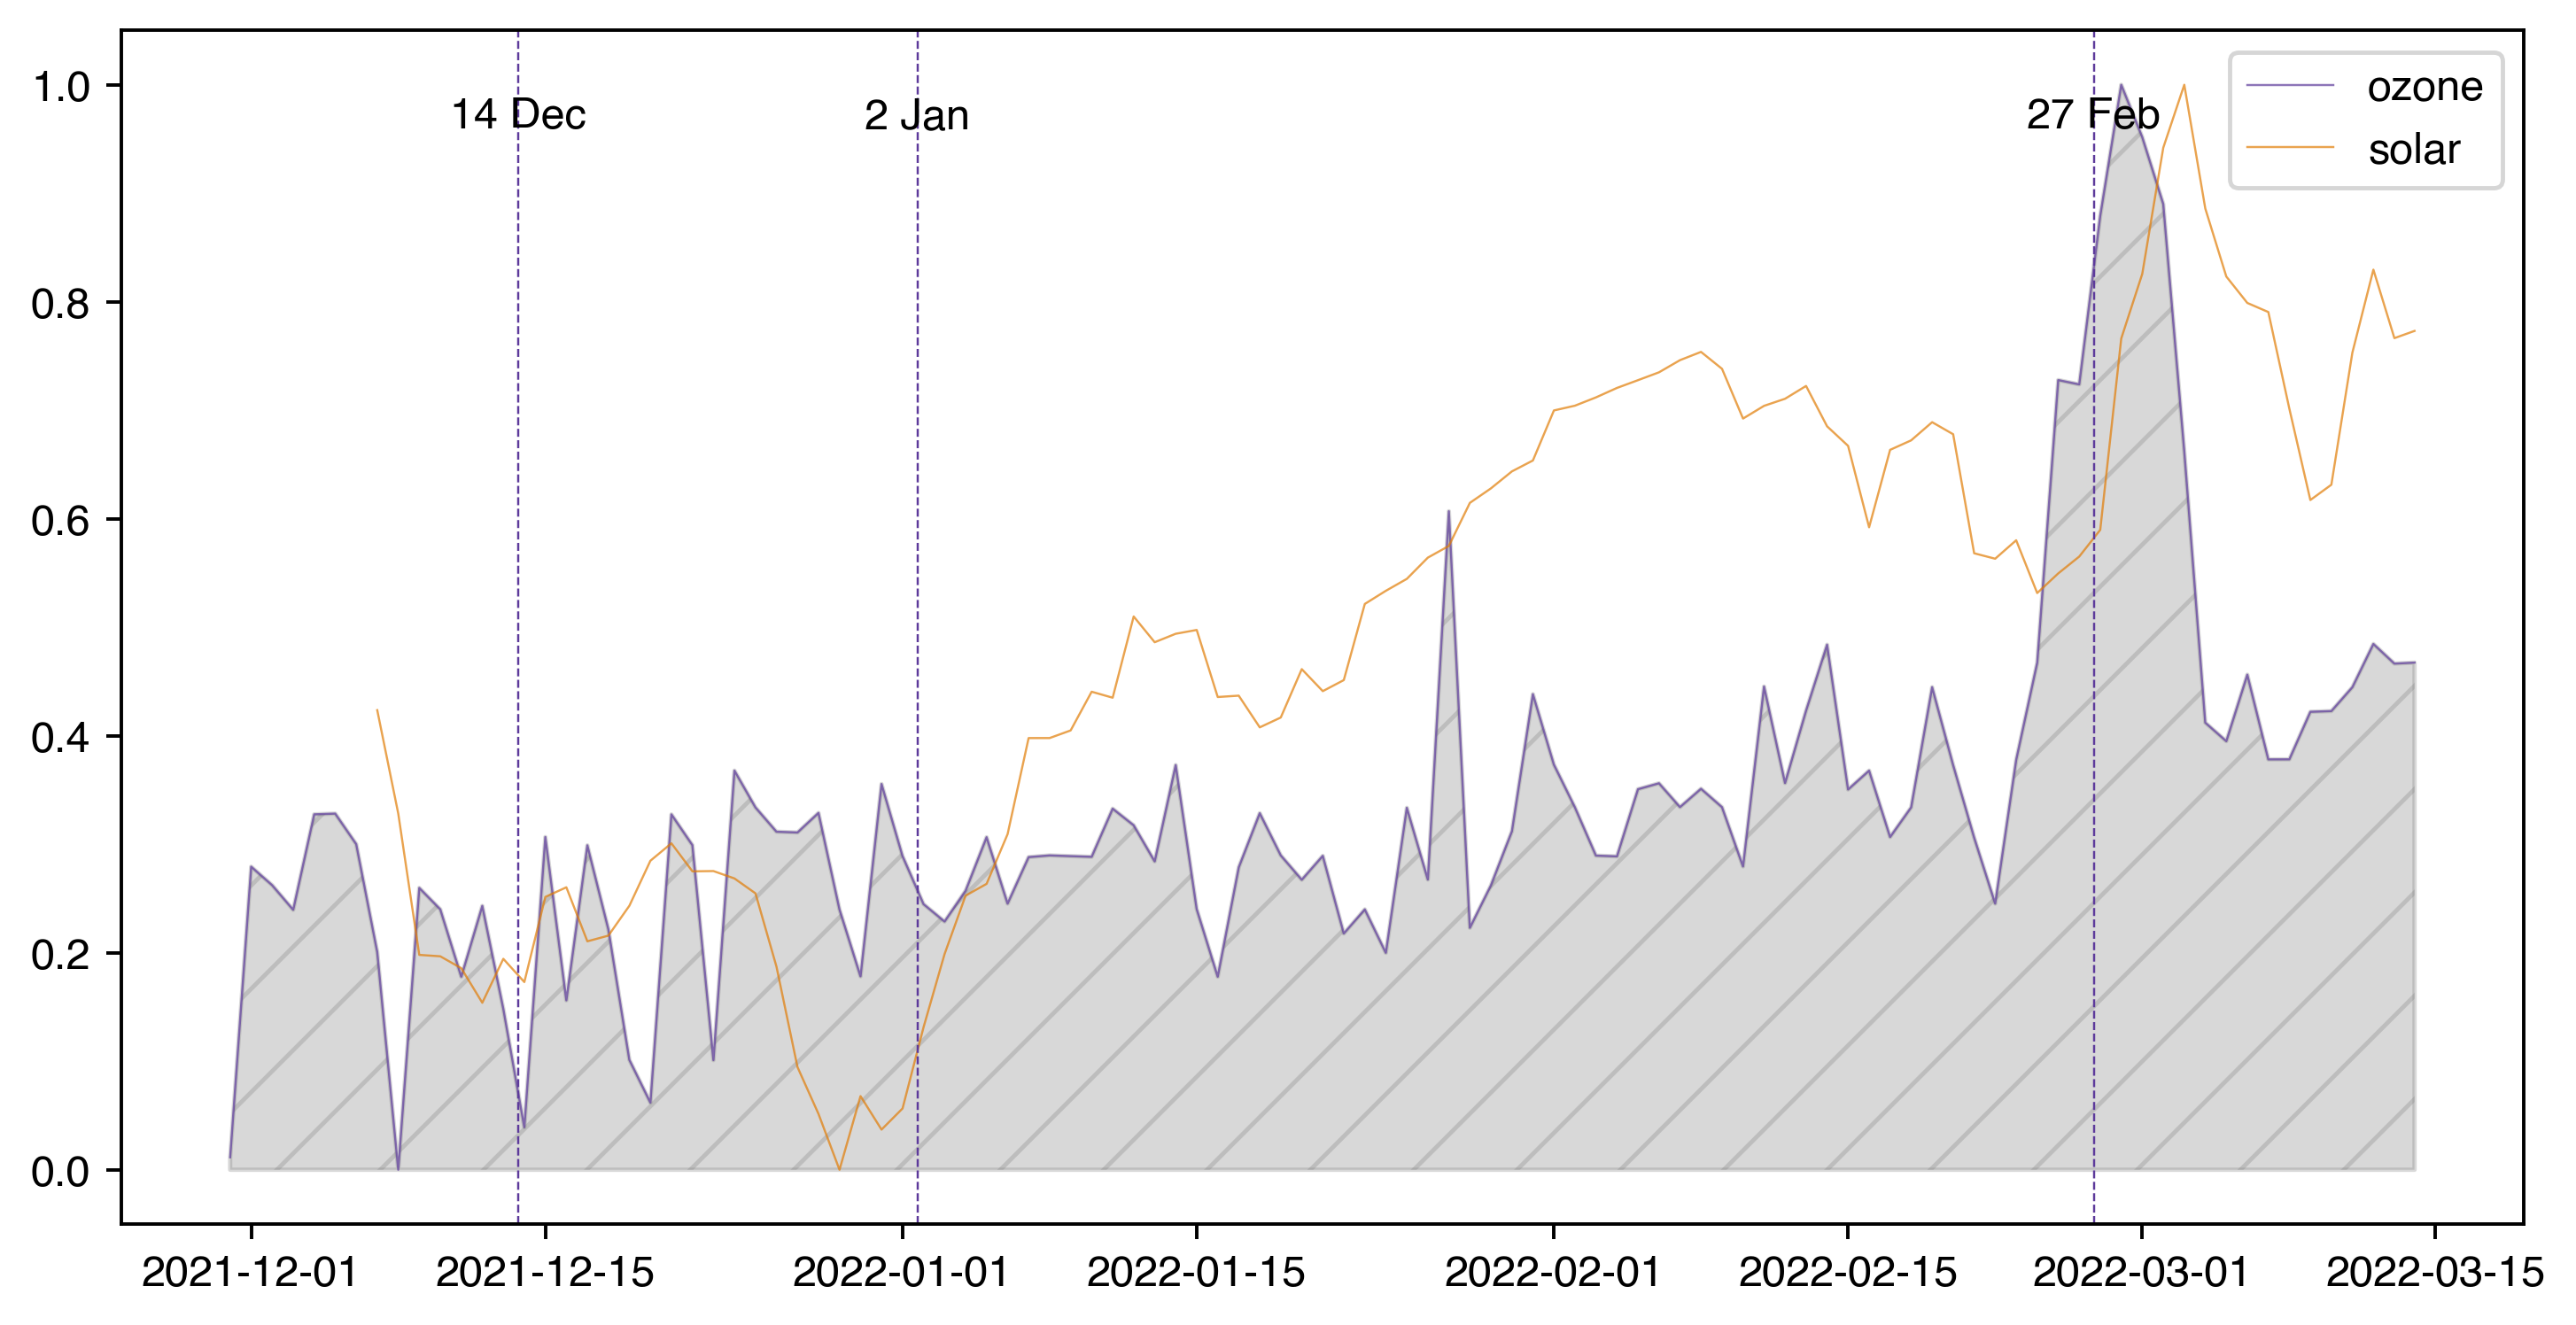

In [45]:
data_dict = {
    "ozone": repr_ozone,
    # "mslp": repr_mslp,
    # "wind": repr_wind,
    # "snow": repr_snow,
    "solar": repr_solar
}
labels = data_dict.keys()
normalize_and_plot(data_dict, labels)

The big difference in the above plot between the two snowfalls event -- one being a high ozone event and the other not -- is key. It looks like solar may be a differentiator? Lapse rate would be diagnosis rather than a discriminator. Not soil temperature as snow stayed. Wind seemed quite calm. 

TODO
* Need to look at synoptic chart about MSLP

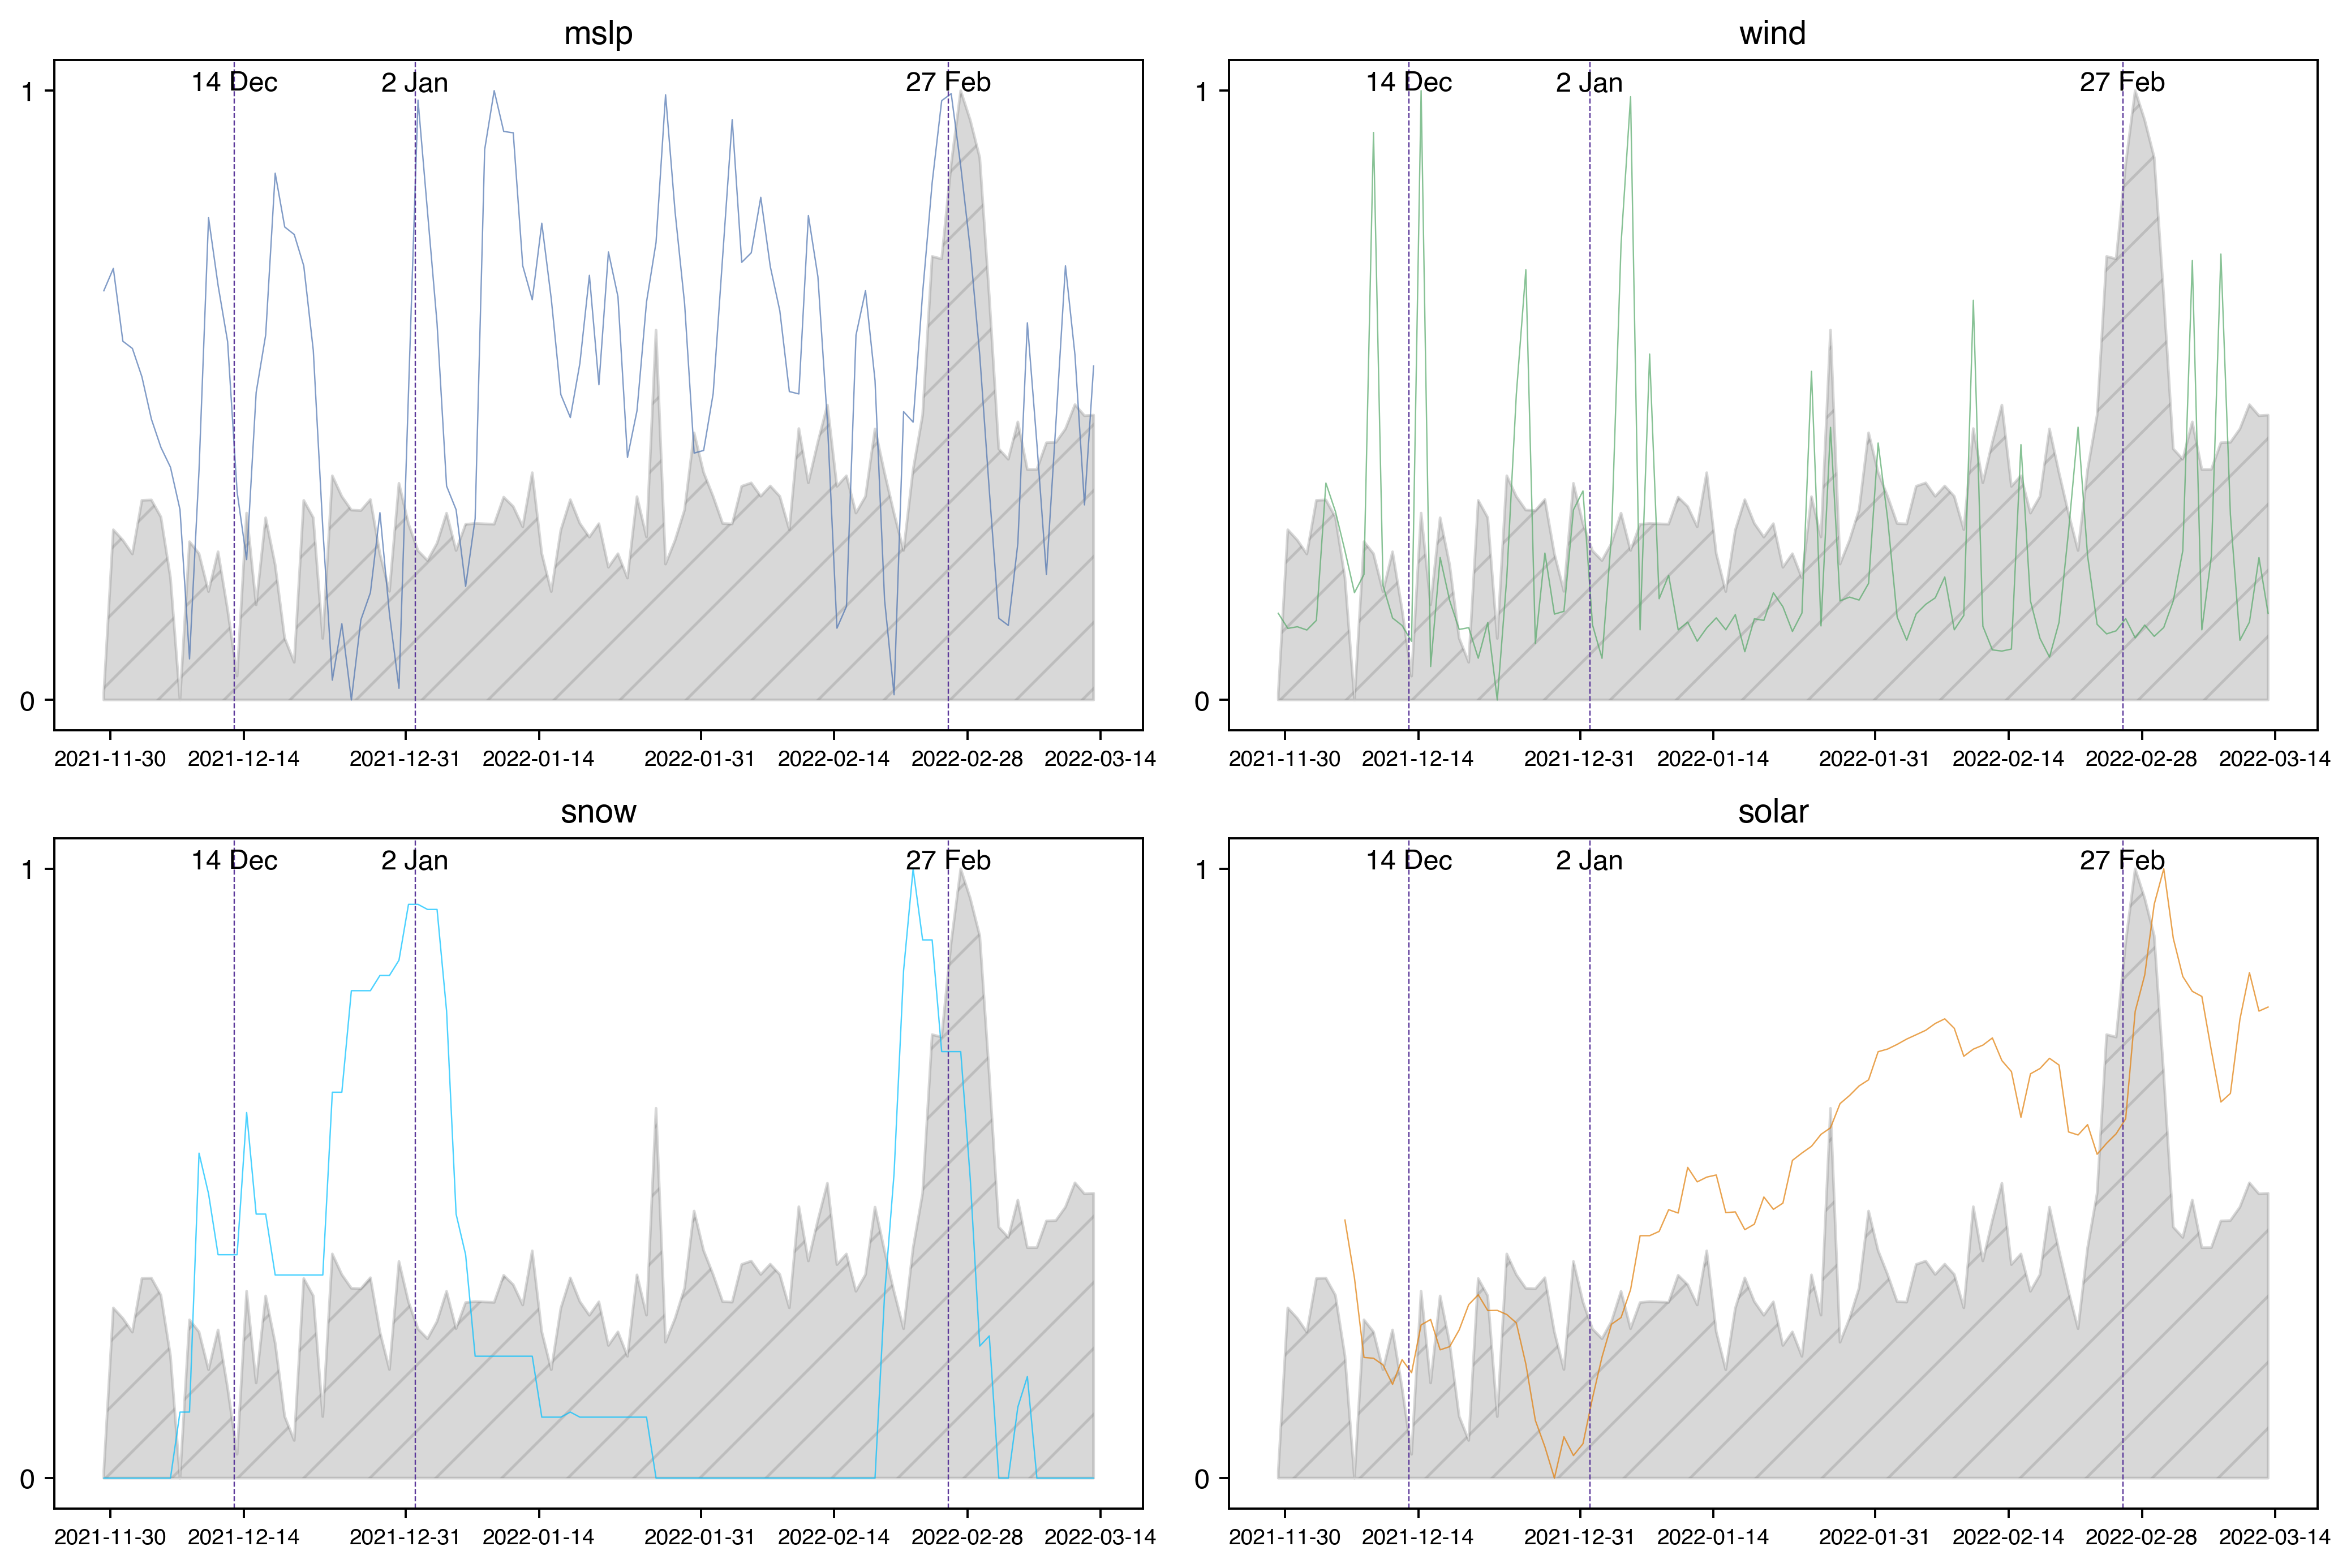

In [52]:
import matplotlib.dates as mdates

def plot_all(data_dict, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()
    ozone_data = data_dict["ozone"]
    if isinstance(ozone_data, pd.DataFrame):
        ozone_data = ozone_data.squeeze()  # Convert DataFrame to Series if necessary
    normalized_ozone = (ozone_data - ozone_data.min()) / (ozone_data.max() - ozone_data.min())

    for ax, label in zip(axs, labels):
        if label == "ozone":
            continue  # Skip plotting ozone as a line, it will be the filled/hatched line

        data = data_dict[label]
        if isinstance(data, pd.DataFrame):
            data = data.squeeze()  # Convert DataFrame to Series if necessary
        normalized_data = (data - data.min()) / (data.max() - data.min())

        ax.plot(data.index, normalized_data, label=label, lw=0.5, alpha=0.7, color=colors[label])
        ax.fill_between(ozone_data.index, normalized_ozone, alpha=0.3, hatch='/', color='gray')
        ax.set_title(label)
        ax.set_yticks([0, 1])  # Set y-ticks to only show 0 and 1

        # Set x-axis major ticks to be half as frequent
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=6))
        ax.tick_params(axis='x', labelsize=8)  # Set smaller font size for x-axis labels
        
        # Plot these days for the 2021/2022 case study
        dates = ['2022-02-27', '2022-01-02', '2021-12-14']
        date_labels = ['27 Feb', '2 Jan', '14 Dec']
        for date, date_label in zip(dates, date_labels):
            date_timestamp = pd.Timestamp(date)
            ax.annotate('', xy=(date_timestamp, 1), xytext=(date_timestamp, 1),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=5, headwidth=10))
            ax.text(date_timestamp, 1, date_label, ha='center', fontsize=10)
            ax.axvline(date_timestamp, color=colors['ozone'], linestyle='--', lw=0.5)

    plt.tight_layout(pad=1.0)  # Reduce padding between subplots
    plt.show()
    return

# Example usage
data_dict = {
    "ozone": repr_ozone,
    "mslp": repr_mslp,
    "wind": repr_wind,
    "snow": repr_snow,
    "solar": repr_solar
}
labels = ["mslp", "wind", "snow", "solar"]
plot_all(data_dict, labels)